In [1]:
import datetime as dt
import pandas as pd 
import numpy as np
import os
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML, display


# Project directories
DATA_SOURCE_DIRECTORY_NAME = "Data source"  # Root folder of the project data
REPORTS_DIRECTORY_NAME = "Reports"
OLD_VERSION_SCRIPTS_DIRECTORY_NAME = "Old version scripts"
DOCUMENTATION_DIRECTORY_NAME = "Documentation"
VMK_DIRECTORY_NAME = "ВМК"
VMK2_DIRECTORY_NAME = "ВМК2"
ROSTELECOM_DIRECTORY_NAME = "Ростелеком"

# Project paths
# Local paths
PATH_DATA_SOURCE = os.path.join(".\\", DATA_SOURCE_DIRECTORY_NAME)
PATH_REPORTS = os.path.join(".\\", REPORTS_DIRECTORY_NAME)
PATH_OLD_VERSION_SCRIPTS = os.path.join(".\\", OLD_VERSION_SCRIPTS_DIRECTORY_NAME)
PATH_DOCUMENTATION = os.path.join(".\\", DOCUMENTATION_DIRECTORY_NAME)

# Network paths
ROOT_PATHS_NETWORK_STORAGE = ["Z:/ОСЦ/PUBLIC/Недозвоны/", "\\\db1\FS\\ОСЦ\\PUBLIC\\Недозвоны\\"]

# If you change the source fields of the loaded tables, 
# you will need to modify the code in the functions: preprocess_dataframe_VMK, preprocess_dataframe_Rostelecom
SOURCE_FIELDS_VMK = ['Номер телефона', 'Время звонка', 'Статус звонка', 'Время ожидания', 'Время разговора', 'Группа', 'Оператор']


# TODO: Уточнить в необходимости использования выходных дней 
holidays = [dt.date(2020,12,31),dt.date(2021,1,1),dt.date(2021,1,2), dt.date(2021,1,3), dt.date(2021,1,4), dt.date(2021,1,5), 
            dt.date(2021,1,6), dt.date(2021,1,7), dt.date(2021,1,8), dt.date(2021,1,9), dt.date(2021,1,10), dt.date(2021,2,22),
            dt.date(2021,2,23), dt.date(2021,3,8), dt.date(2021,5,3),dt.date(2021,5,4), dt.date(2021,5,5), dt.date(2021,5,6), 
            dt.date(2021,5,7), dt.date(2021,5,10), dt.date(2021,11,4), dt.date(2021,11,5)]
   

# Создание структуры проекта
def create_folder(path):
        if not os.access(path, os.F_OK):
            os.mkdir(path)

            
def create_structur_folders():
    create_folder(path=PATH_DATA_SOURCE)
    create_folder(path=PATH_REPORTS)
    create_folder(path=PATH_OLD_VERSION_SCRIPTS)
    create_folder(path=PATH_DOCUMENTATION)


# Определение путей к директориям ВМК, ВМК2, Ростелеком
def define_paths_for_data():
    paths_dict = {"path_vmk": None, "path_vmk2": None, "path_rostelecom": None}
    
    if IS_LOCAL_STORAGE:
        return creat_paths_for_data(paths_dict=paths_dict, root_path_for_data=PATH_DATA_SOURCE)
    else: 
        for root_network_path in ROOT_PATHS_NETWORK_STORAGE:
            if os.access(root_network_path, os.F_OK):
                return creat_paths_for_data(paths_dict=paths_dict, root_path_for_data=root_network_path)
        
        print('Не удалось определить пути на сетевом хранилище до директорий: '  
            + f'{VMK_DIRECTORY_NAME}, {VMK2_DIRECTORY_NAME}, {ROSTELECOM_DIRECTORY_NAME}.'
            + '\nПроверти сетевое подключение или воспользуйтесь локальным хранилищем данных')
        return paths_dict
        
    
def creat_paths_for_data(paths_dict, root_path_for_data):
    paths_dict["path_vmk"] = os.path.join(root_path_for_data, VMK_DIRECTORY_NAME)
    paths_dict["path_vmk2"] = os.path.join(root_path_for_data, VMK2_DIRECTORY_NAME)
    paths_dict["path_rostelecom"] = os.path.join(root_path_for_data, ROSTELECOM_DIRECTORY_NAME)
    return paths_dict  


# Stage eject data
def load_one_table(path_storage, file_name, start_hour_job, end_hour_job, is_VMK=False):
    path_load_file = os.path.join(path_storage, str(file_name) + ".xlsx")
    print(path_load_file)
    if os.access(path_load_file, os.F_OK):
        if is_VMK:
            load_df = pd.read_excel(path_load_file)
            load_df = preprocess_dataframe_VMK(preprocess_df=load_df, start_hour_job=start_hour_job, end_hour_job=end_hour_job)
            return load_df
        else:   
            date=re.search( r'[0-9]{4}-[0-9]{2}-[0-9]{2}', path_load_file).group()
            df_RT = pd.read_excel(path_load_file, dtype={'Номер вызывающего': str})
            if (dt.datetime.strptime(date, "%Y-%m-%d") < dt.datetime(2021,4,22)):
                df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')        
                df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: int(x.split(' ')[0])*60+int(x.split(' ')[1]) if len(x.split(' '))==2 else int(x.split(' ')[0]))
            else:
                df_RT['Длительность']=pd.to_timedelta(df_RT['Длительность'].astype('str'))
                df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: x.total_seconds())
            
            df_RT= df_RT[['Дата вызова','Время вызова','Номер вызывающего','Номер вызываемого', 'Первый ответивший', 'Статус', 'Длительность', 'Группа']]
            df_RT['Номер вызываемого']=df_RT['Номер вызываемого'].astype('str')
            df_RT['Время вызова']=df_RT['Время вызова'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S'))
            df_RT['Дата вызова']=pd.to_datetime(df_RT['Дата вызова'])
            df_RT['День недели']=df_RT['Дата вызова'].apply(lambda x: x.weekday())
            df_RT['Час звонка']=df_RT['Время вызова'].dt.hour
            df_RT['Время вызова']=df_RT['Время вызова'].dt.time 
            
            df_RT = preprocess_dataframe_Rostelecom(df_RT)
            df_RT = df_RT[(df_RT['Час звонка'] >= start_hour_job) & (df_RT['Час звонка'] < end_hour_job)] 
            return df_RT 
    else:
        print(f"Файл {str(file_name) + '.xlsx'} НЕ НАЙДЕН в директории: {path_storage}")
        return None

def create_df(names):
    cont = []
    for i in range(len(names)):
        if '~$' in names[i]:
            continue
        df = pd.read_excel(names[i], engine='openpyxl')
        df = preprocess_dataframe_VMK(df)
        
        df['Группа'] = df['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования', 'кнопка 1':'Мобилизация'})
        # Костыль, устранение пустых значений у данных полей. Значения заменяются на медианные
        df['Время разговора'] = df['Время разговора'].apply(lambda x: x if str(x) != "nan" else  round(df['Время разговора'].median(), 6))
        df['Время ожидания'] = df['Время ожидания'].apply(lambda x: x if str(x) != "nan" else  round(df['Время ожидания'].median(), 6))

        cont.append(df)
    return pd.concat(cont) 


# stage preprocess data
def preprocess_dataframe_VMK(preprocess_df, start_hour_job, end_hour_job):
    """
    
    """
    data_copy_from_site = True
    
    # Проверка на скачен файл ли сайта
    if list(preprocess_df.columns) != SOURCE_FIELDS_VMK:
        list_index = list()
        
        for i in range(len(preprocess_df)):
            list_index.append(i)  
            if 'Номер телефона' in tuple(preprocess_df.iloc[i]):
                preprocess_df.columns = preprocess_df.iloc[i]
                preprocess_df.columns.name=None
                preprocess_df = preprocess_df.drop(index=list_index)
                preprocess_df.reset_index(inplace=True, drop=True)
                
                data_copy_from_site = False
                break
    
    preprocess_df['Время звонка'] = preprocess_df['Время звонка'].astype('str')
    preprocess_df['Время ожидания'] = pd.to_timedelta(preprocess_df['Время ожидания'].astype('str'))
    preprocess_df['Время разговора'] = pd.to_timedelta(preprocess_df['Время разговора'].astype('str'))
    
    if data_copy_from_site:
        preprocess_df = preprocess_df.groupby((preprocess_df[['Номер телефона']].isnull()==False).all(1).cumsum()).agg({'Время звонка': ' '.join, 'Номер телефона': 'first', 'Статус звонка': 'first',
                    'Время ожидания': 'first', 'Время разговора': 'first',
                    'Группа': 'first', 'Оператор': 'first'})
        preprocess_df['Время звонка'] = preprocess_df['Время звонка'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S %Y-%m-%d 00:00:00'))
    else:
        preprocess_df['Время звонка'] = preprocess_df['Время звонка'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        
    preprocess_df['Дата звонка'] = preprocess_df['Время звонка'].dt.date
    preprocess_df['День недели'] = preprocess_df['Время звонка'].apply(lambda x: x.weekday())
    preprocess_df['Час звонка'] = preprocess_df['Время звонка'].dt.hour
    preprocess_df['Время звонка'] = preprocess_df['Время звонка'].dt.time

    preprocess_df['Время ожидания'] = preprocess_df['Время ожидания'].apply(lambda x: x.total_seconds()/60)
    preprocess_df['Время разговора'] = preprocess_df['Время разговора'].apply(lambda x: x.total_seconds()/60)
    
    preprocess_df['Оператор'] = preprocess_df['Оператор'].replace({np.nan:None})
    preprocess_df['Отчетная дата'] = preprocess_df['Дата звонка'] + dt.timedelta(days=1) 
    
    
    # Из загрузки
    preprocess_df = preprocess_df[(preprocess_df['Час звонка'] >= start_hour_job) & (preprocess_df['Час звонка'] < end_hour_job)]
    preprocess_df['Группа'] = preprocess_df['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования', 'кнопка 1':'Мобилизация'})
    
    # Костыль, устранение пустых значений у данных полей. Значения заменяются на медианные
    preprocess_df['Время разговора'] = preprocess_df['Время разговора'].apply(lambda x: x if str(x) != "nan" else  round(preprocess_df['Время разговора'].median(), 6))
    preprocess_df['Время ожидания'] = preprocess_df['Время ожидания'].apply(lambda x: x if str(x) != "nan" else  round(preprocess_df['Время ожидания'].median(), 6))

    
    return preprocess_df


def preprocess_dataframe_Rostelecom(df):
    df = df.rename(columns={'Первый ответивший': 'Оператор'})
    df['Группа']=df['Группа'].replace({'Общая':'Медколледж','Консультация':'Облкомобразования'})
    df['Группа']=df['Группа'].fillna('Не определена')
    df['Оператор']=df['Оператор'].replace({' ':'Не определен'})

    # Фильтрация звонков по условию
    # В фрейме данных не отсекаются номера у поля «Номер вызывающего».
    df = df[df['Длительность'] > 9]
    df = df.drop(df[(df['Группа'] =='Не определена') & (df['Статус'] =='пропущенный')].index)
    df = df.drop(df[(df['Длительность'] < 120) & (df['Статус'] =='пропущенный')].index)

    df['Номер вызывающего']=df['Номер вызывающего'].str.replace(' ', '')
    df['Номер вызываемого']=df['Номер вызываемого'].str.replace(' ', '')
    hospitals=pd.read_excel(os.path.join(".\\", DATA_SOURCE_DIRECTORY_NAME, 'Переадресация телефонов.xlsx'))
    df=df.merge(hospitals, how = 'left', left_on='Номер вызывающего', right_on='Единый номер')

    df['Наименование учреждения'] = df['Наименование учреждения'].str.replace('Государственное учреждение здравоохранения','ГУЗ')
    df['Наименование учреждения'] = df['Наименование учреждения'].str.replace('Государственное бюджетное учреждение здравоохранения','ГБУЗ') 
    df['Наименование учреждения'] = df['Наименование учреждения'].str.replace('Клиническая больница скорой медицинской помощи','КБСМП')
    df['Наименование учреждения'] = df['Наименование учреждения'].str.replace('клиническая поликлиника','КП')
    return df


def check_df_on_none(df):
    if df.shape[0] != 0:
        return True
    else:
        print("ВНИМАНИЕ!\nНе удалось выполнить фрагмент кода. Данные в DataFrame отсутствуют!") 
        return False
  

def table_waiting_time(total):
    total['Ждали']=total['Время ожидания'].apply(lambda x: x*60)
    total['Ждали']= total.apply(lambda row: row['Ждали'], axis=1)
    total['Время ожидания звонка']=total['Ждали'].apply(lambda x: dt.time(int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60)))
    #table = total_all_days.sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка']].copy()
    table = total.sort_values(by='Время ожидания', ascending=False).loc[:,('Дата звонка', 'Номер телефона', 'Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка')]
#     print(table)
    return table


def table_waiting_time2(total_all_days):
    total_all_days['Ждали']=total_all_days['Время ожидания'].apply(lambda x: x*60)
    total_all_days['Ждали']= total_all_days.apply(lambda row: row['Ждали'], axis=1)
    total_all_days['Время ожидания звонка']=total_all_days['Ждали'].apply(lambda x: dt.time(int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60)))
    #table = total_all_days.sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка']].copy()
    table = total_all_days.sort_values(by='Время ожидания', ascending=False).loc[:,('Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка')]
    return table


# -
def calculate_statistics(dataframe, title):
    if check_df_on_none(dataframe):
        reporting_date = dataframe['Дата звонка'].values[0]

        day = dataframe[(dataframe['Час звонка'] >=0 ) & (dataframe['Час звонка']  < 24)]
        night = dataframe[(dataframe['Час звонка'] < 0) | (dataframe['Час звонка'] >= 24)]
        oper_df=dataframe[(dataframe['Оператор'].notna()) & (dataframe['Оператор']!='--')]

        # Рассчитываем количество операторов в рабочее время (c 8:00 по 20:00)
        work_day_df = oper_df[(oper_df['Час звонка']>=0) & (oper_df['Час звонка'] < 24)]
        all_oper_day = len(work_day_df['Оператор'].unique())
        oper_day=len(work_day_df[work_day_df['Статус звонка']!='Не дождался'] ['Оператор'].unique())

        # Рассчитываем количество операторов в НЕ рабочее время
        not_work_day_df = oper_df[(oper_df['Час звонка'] < 0) | (oper_df['Час звонка'] >= 24)]
        all_oper_night = len(not_work_day_df['Оператор'].unique())
        oper_night=len(not_work_day_df[not_work_day_df['Статус звонка']!='Не дождался'] ['Оператор'].unique())
        all_oper = len(oper_df['Оператор'].unique())


        # Рассчитываем количество званков всего
        all_calls = dataframe.shape[0]
        # Рассчитываем количество званков ночью
        all_night_calls = night.shape[0]
        # Рассчитываем количество званков днём
        all_work_day_calls = day.shape[0]


        # Рассчитываем количество пропущенных всего званков
        all_missed_calls=dataframe[dataframe["Статус звонка"]=='Не дождался'].shape[0]
        # Рассчитываем количество пропущенных званков днём
        day_missed_calls = day[day["Статус звонка"]=='Не дождался'].shape[0]
        # Рассчитываем количество пропущенных званков ночью
        night_missed_calls = night[night["Статус звонка"]=='Не дождался'].shape[0]


        # Рассчитываем среднее время разговора за сутки
        mean_talk=np.round(dataframe['Время разговора'].mean(),1)
        # Рассчитываем среднее время разговора за день
        day_mean_talk=np.round(day['Время разговора'].mean(),1)
        # Рассчитываем среднее время разговора за ночь
        night_mean_talk = np.round(night['Время разговора'].mean(),1)


        # Рассчитываем максимальнок время ожидание
        max_wait_df = dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]
        # За сутки
        max_wait=np.round(dataframe['Время ожидания'].max(),1)
        time_with_max_wait = max_wait_df['Время звонка'].values[0]
        # За день
        max_wait_day_df = day[day['Время ожидания']==day['Время ожидания'].max()]
        max_wait_day = np.round(day['Время ожидания'].max(),1)
        time_with_max_wait_day = max_wait_day_df['Время звонка'].values[0]
        # За ночь
        max_wait_night_df = night[night['Время ожидания'] == night['Время ожидания'].max()]
        max_wait_night = np.round(night['Время ожидания'].max(),1)    
        time_with_max_wait_night =  0 if max_wait_night_df.empty else max_wait_night_df['Время звонка'].values[0]    


        # Рассчитываем у какого оператора было максимальнок время ожидание и в какой он группе
        # За сутки
        group_with_max_wait = max_wait_df['Группа'].values[0]
        oper__with_max_wait = max_wait_df['Оператор'].values[0]
        # За день
        group_with_max_wait_day = max_wait_day_df['Группа'].values[0]
        oper__with_max_wait_day = max_wait_day_df['Оператор'].values[0]
        # За ночь
        group_with_max_wait_night = 0 if max_wait_night_df.empty else max_wait_night_df['Группа'].values[0]
        oper__with_max_wait_night = 0 if max_wait_night_df.empty else max_wait_night_df['Оператор'].values[0]


        # Рассчитываем среднее время ожидание
        all_wait = dataframe['Время ожидания']
        day_wait = day['Время ожидания']
        night_wait = night['Время ожидания']
        # За сутки
        mean_wait = np.round(all_wait.mean(),5)
        # За день
        mean_wait_day = np.round(day_wait.mean(),5)
        # За ночь
        mean_wait_night = np.round(night_wait.mean(),5)

        # Рассчитываем ожидание более 3 минут
        # За сутки
        more_3_min_df = dataframe[all_wait >= 3].shape[0]
        more_3_min = np.round(more_3_min_df * 100 / all_calls, 0)
        # За день
        more_3_min_day_df = day_wait[day_wait >= 3].shape[0]
        more_3_min_day = np.round(more_3_min_day_df * 100 / all_calls, 0)
        # За ночь
        more_3_min_night_df = night_wait[night_wait >= 3].shape[0]
        more_3_min_night = np.round(more_3_min_df * 100 / all_calls, 0)

        # За сутки
        print(f'{title}\nза {reporting_date}\n')
        print('Информация за сутки: \n')
        print(f'Число операторов всего: {all_oper},\nВсего звонков {all_calls}, неотвеченных вызовов: {all_missed_calls}')
        print(f'Среднее время разговора за сутки (мин): {mean_talk}')
        print(f'Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait})')
        print(f'Среднее время ожидания за сутки(мин): {mean_wait}')
        print(f'Ожидание более 3 минут за сутки (%): {more_3_min}\n')

        # За день
        print('\nИнформация за рабочий день (с 8:00 до 20:00): \n')
        print(f'Число операторов днем {all_oper_day}, из них {oper_day} отвечали на звонки')
        print(f'Днем позвонили {all_work_day_calls} раз, из них неотвеченных вызовов: {day_missed_calls}')
        print(f'Среднее время разговора денём (мин): {day_mean_talk}')
        print(f'Максимальное время ожидания днём (мин): {max_wait_day} (Оператор: {oper__with_max_wait_day}, Группа: {group_with_max_wait_day}, Время звонка: {time_with_max_wait_day})')
        print(f'Среднее время ожидания днём (мин): {mean_wait_day}')
        print(f'Ожидание более 3 минут днём (%): {more_3_min_day}\n')

        # За ночь
        print('\nИнформация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): \n')
        print(f'Число операторов ночью {all_oper_night}, из них {oper_night} отвечали на звонки')
        print(f'Ночью позвонили {all_night_calls} раз, из них неотвеченных вызовов: {night_missed_calls}')      
        print(f'Среднее время разговора ночью (мин): {night_mean_talk}')
        print(f'Максимальное время ожидания ночью (мин): {max_wait_night} (Оператор: {oper__with_max_wait_night}, Группа: {group_with_max_wait_night}, Время звонка: {time_with_max_wait_night})')    
        print(f'Среднее время ожидания ночью (мин): {mean_wait_night}')
        print(f'Ожидание более 3 минут ночью (%): {more_3_min_night}')
             
   
# РОСТЕЛЕКОМ
# Определение зон
def give_missed_calls_zone(percentage):
    zone = ''
    if (percentage >= 15):
        zone = 'красная'
    elif ( 5 < percentage < 15):
        zone = 'желтая'
    else:
        zone = 'зеленая'
    return zone


def give_mean_wait_zone(time_wait):
    zone = ''
    if (time_wait > 10):
        zone = 'красная'
    elif ( 2 < time_wait <= 10):
        zone = 'желтая'
    else:
        zone = 'зеленая'
    return zone


# Cчитаем отчёт для ЕА
def report_for_EA(df_VMK, df_RT):
    if check_df_on_none(df_VMK) and check_df_on_none(df_RT):
        # дата отчёта
        report_data = df_VMK['Дата звонка'].values[0].strftime("%d.%m.%Y")
        # всего звонков
        all_calls = df_RT[df_RT['Номер вызываемого']=='78442325552'].shape[0]
        # количество неотвеченных
        missed_calls_count = df_RT[(df_RT['Статус']=='пропущенный') & (df_RT['Номер вызываемого']=='78442325552')].shape[0]   
        # Рассчитываем процент недозвонов    
        percentage_missed = np.round(missed_calls_count/all_calls * 100, 2)
        missed_calls_zone = give_missed_calls_zone(percentage_missed)
        # Рассчитываем среднее время ожидания
        mean_wait = np.round(df_VMK['Время ожидания'].mean(),3)
        mean_wait_zone = give_mean_wait_zone(mean_wait)
            
        print(f"""Информация по вызовам на "122" за {report_data}:
    Всего вызовов: {all_calls}
    Неотвеченных вызовов: {missed_calls_count} ( {str(percentage_missed).replace('.',',')}%, {missed_calls_zone} зона)
    Среднее время ожидания: {str(mean_wait).replace('.',',')} мин. ({mean_wait_zone} зона)
    """)   


# def rename_df_RT(dataframeRT):
#     dataframeRT = dataframeRT.rename(columns={'Первый ответивший': 'Оператор'})
#     dataframeRT['Группа']=dataframeRT['Группа'].fillna('Не определена')
#     dataframeRT['Оператор']=dataframeRT['Оператор'].replace({' ':'Не определен'})

#     dataframeRT = dataframeRT.drop(dataframeRT[(dataframeRT['Группа'] =='Не определена') & (dataframeRT['Статус'] =='пропущенный')].index)
#     dataframeRT = dataframeRT.drop(dataframeRT[(dataframeRT['Длительность'] < 120) & (dataframeRT['Статус'] =='пропущенный')].index)
#     dataframeRT['Номер вызывающего']=dataframeRT['Номер вызывающего'].str.replace(' ', '')
#     dataframeRT['Номер вызываемого']=dataframeRT['Номер вызываемого'].str.replace(' ', '')


#     hospitals=pd.read_excel(os.path.join(".\\", NAME_DIRICTORY_FOR_DATA_SOURCE, 'Переадресация телефонов.xlsx'))
#     dataframeRT=dataframeRT.merge(hospitals, how = 'left', left_on='Номер вызывающего', right_on='Единый номер')

#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('Государственное учреждение здравоохранения','ГУЗ')
#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('Государственное бюджетное учреждение здравоохранения','ГБУЗ') 
#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('Клиническая больница скорой медицинской помощи','КБСМП')
#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('клиническая поликлиника','КП')
#     return dataframeRT
# total_all_days_RT = rename_df_RT(total_all_days_RT)
# #total_all_days_RT = total_all_days_RT[total_all_days_RT['Дата вызова'] == '2022-02-10'] 
# total_all_days_RT
# # x = total_all_days_RT['Дата вызова'].values[0]
# # print(x)
# # print(type(x))
# # total_all_days_RT


def calculate_statistics_RT(dataframe):
    if check_df_on_none(dataframe):
        all_calls_count=dataframe.shape[0]
        all_calls_5552_count=dataframe[dataframe['Номер вызываемого']=='78442325552'].shape[0]
        all_calls_5554_count=dataframe[dataframe['Номер вызываемого']=='78442325554'].shape[0]
        missed_calls=dataframe[dataframe['Статус']=='пропущенный']
        missed_calls_count=missed_calls.shape[0]
        missed_calls_5552_count=missed_calls[missed_calls['Номер вызываемого']=='78442325552'].shape[0]
        missed_calls_5554_count=missed_calls[missed_calls['Номер вызываемого']=='78442325554'].shape[0]
        
        hospital_calls=dataframe[dataframe['Наименование учреждения'].isnull()==False]
        hospital_calls_count=hospital_calls.shape[0]
        hospital_calls_count_5552=hospital_calls[hospital_calls['Номер вызываемого']=='78442325552'].shape[0]
        hospital_calls_count_5554=hospital_calls[hospital_calls['Номер вызываемого']=='78442325554'].shape[0]
        
        print('По выгрузке Ростелекома: неотвеченных вызовов - {0} %'.format(np.round(missed_calls_5552_count / all_calls_5552_count*100,2)))
        print('Всего вызовов – {0}, неотвеченных – {1} (отфильтровано менее 120 сек, а также по группе "Не определена").'.format(all_calls_5552_count, missed_calls_5552_count))


def calculate_statistics_WMK(dataframe, report_one_day=True):
    if check_df_on_none(dataframe):      
        # Рассчитываем максимальнок время ожидание
        max_wait_df = dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]
        group_with_max_wait = max_wait_df['Группа'].values[0]
        oper__with_max_wait = max_wait_df['Оператор'].values[0]    
        max_wait=np.round(dataframe['Время ожидания'].max(),1)
        time_with_max_wait = max_wait_df['Время звонка'].values[0]    
        report_data = dataframe['Дата звонка'].values[0].strftime("%d.%m.%Y")
        report_data_time = dt.datetime.now().strftime("%H:%M")
        
        if report_one_day:
            print(f"""
Информация по вызовам по состоянию на {report_data_time} за {report_data}.
Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait}))
            """)
        else:
            print(f"""
Информация по вызовам по состоянию с 8:00 {dataframe['Дата звонка'].min().strftime('%d.%m.%Y')} по 8:00 {dataframe['Дата звонка'].max().strftime('%d.%m.%Y')}.
Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait}))
            """)    
        

def calculate_values_for_report_vmk(df):
    report_mob_vmk_values = {'total_number_calls': None, 'SL_for_10_minutes': None, 'max_time_wait_call': None, 'mean_time_wait_call': None,
                                'mean_time_talked_on_phone': None, 'list_users_work_for_day': None, 'number_users_work_for_day': None, 
                                'description_keys': {'total_number_calls': 'Общее количество звонков' , 'SL_for_10_minutes': 'SL за 10 сек., %',
                                'max_time_wait_call': 'Максимальное время ожидания ответа от оператора', 'mean_time_wait_call': 'Среднее время ожидания ответа от оператора',
                                'mean_time_talked_on_phone': 'Среднее время разговора', 'list_users_work_for_day': 'Cписок пользователей, работающих в течение дня',
                                'number_users_work_for_day': 'Количество пользователей, работающих в течение дня'}}

    if check_df_on_none(df):
        report_mob_vmk_values['total_number_calls'] = df.shape[0]
        report_mob_vmk_values['SL_for_10_minutes'] =  round(df[df['Время ожидания']  < 0.17].shape[0] / report_mob_vmk_values.get('total_number_calls') * 100 
                                                        if report_mob_vmk_values.get('total_number_calls') != 0 else 0.00 , 2)
        
        report_mob_vmk_values['max_time_wait_call'] = round(df['Время ожидания'].max(), 1) if report_mob_vmk_values.get('total_number_calls') > 0 else 0
        report_mob_vmk_values['mean_time_wait_call'] = round(df['Время ожидания'].mean(), 1) if report_mob_vmk_values.get('total_number_calls') > 0 else 0
        report_mob_vmk_values['mean_time_talked_on_phone'] = round(df['Время разговора'].mean(), 1) if report_mob_vmk_values.get('total_number_calls') > 0 else 0
        
        tmp_list_users = [user for user in df.Оператор.unique() if 'user' in user]
        tmp_list_users.sort()
        report_mob_vmk_values['list_users_work_for_day'] = ", ".join(tmp_list_users)
        report_mob_vmk_values['number_users_work_for_day'] = len(tmp_list_users)
    return report_mob_vmk_values

    
def print_calculate_statistics_VMK_mob(dict_values):
    print(f"1. Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации: {dict_values.get('total_number_calls')}")
    print(f"2. SL за 10 сек., %: {dict_values.get('SL_for_10_minutes')}")
    print(f"3. Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации: {dict_values.get('max_time_wait_call')}")
    print(f"4. Среднее время ожидания на линии консультаций по вопросам частичной мобилизации: {dict_values.get('mean_time_wait_call')}")
    print(f"5. Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации: {dict_values.get('mean_time_talked_on_phone')}")


# Create project directories 
create_structur_folders()

# Настройка параметров для ВМК, ВМК2 и Ростелекома

In [2]:
# Выбираем день для расчета статистики по ВМК, ВМК2 и Ростелекому
DAY_STATICTICS_CALCULATION = dt.date(2022,12,18)

# Задаем время работы в колл-центре
START_HOUR_JOB = 0
END_HOUR_JOB = 24

# Дата для отчета с 8:00 текущего дня и до 8:00 следущего дня
# Обязательно указать дату дня (первого) с 8:00 до 24:00
DAY_STATICTICS_CALCULATION_FROM_8_to_8 = dt.date(2022,10,29)

# Расположение хранилища файлов
# Выберете значение True для использования локального хранилища данных, а False для сетевого
IS_LOCAL_STORAGE = True


# Дополнительные настройки 
# При необходимости можно задать разные отчетные даты для  ВМК, ВМК2 и Ростелекома
DAY_STATICTICS_CALCULATION_VMK1 =  DAY_STATICTICS_CALCULATION
DAY_STATICTICS_CALCULATION_VMK2 =  DAY_STATICTICS_CALCULATION
DAY_STATICTICS_CALCULATION_ROSTELECOM =  DAY_STATICTICS_CALCULATION

### Формирование DataFrame за один день для ВМК, ВМК2 и Ростелеком

In [3]:
# Определение путей к хранилищам файлов
data_project_paths  = define_paths_for_data()
PATH_VMK = data_project_paths.get("path_vmk")
PATH_VMK2 = data_project_paths.get("path_vmk2")
PATH_ROSTELECOM = data_project_paths.get("path_rostelecom")

if PATH_VMK is not None and PATH_VMK2 is not None and PATH_ROSTELECOM is not None:
    # ВМК
    # Создаём датафрейм ВМК первый домен (все группы) 
    # df_specific_day = total_all_days[total_all_days['Дата звонка']== DAY_STATICTICS_CALCULATION_VMK1].copy()
    df_specific_day = load_one_table(path_storage=PATH_VMK, file_name=(DAY_STATICTICS_CALCULATION_VMK1 + dt.timedelta(1)), 
                                        start_hour_job=START_HOUR_JOB, end_hour_job=END_HOUR_JOB, is_VMK=True)
    
    # TODO: reporting_date - проеврить возможность замены на DAY_STATICTICS_CALCULATION
    reporting_date = df_specific_day['Дата звонка'].values[0]

print(PATH_VMK)
print(DAY_STATICTICS_CALCULATION)    

.\Data source\ВМК\2022-12-19.xlsx
.\Data source\ВМК
2022-12-18


In [4]:
test_vmk = pd.read_excel('.\\Data source\\ВМК\\2022-12-19.xlsx')
test_vmk2 = pd.read_excel('.\\Data source\\ВМК\\2022-08-17.xlsx')

print(test_vmk.iloc[8][0])
print(type(test_vmk.iloc[0][0]))

print(list(test_vmk2.columns) == SOURCE_FIELDS_VMK)


test_vmk
SOURCE_FIELDS_VMK = "Номер телефона	Время звонка	Статус звонка	Время ожидания	Время разговора	Группа	Оператор".split('\t')
print(SOURCE_FIELDS_VMK)

Номер телефона
<class 'str'>
True
['Номер телефона', 'Время звонка', 'Статус звонка', 'Время ожидания', 'Время разговора', 'Группа', 'Оператор']


In [ ]:
class test:
    def __init__(self) -> None:
        self.test_var = 123

In [ ]:
# Создаём датафрейм ВМК первый домен для здрава (исключена группа: кнопка 1)
    df_specific_day_for_medical = df_specific_day.drop(df_specific_day[df_specific_day['Группа'] == 'Мобилизация'].index).copy()


    # ВМК2
    # Создаём датафрейм ВМК2 второй домен (все группы) 
    df_specific_day2 = load_one_table(path_storage=PATH_VMK2, day_statictics_calculation=(DAY_STATICTICS_CALCULATION_VMK2 + dt.timedelta(1)), 
                                    start_hour_job=START_HOUR_JOB, end_hour_job=END_HOUR_JOB, is_VMK=True)
    reporting_date2 = df_specific_day2['Дата звонка'].values[0]


    # Ростелеком
    # Создаём датафрейм Ростелеком первый домен (все группы) 
    df_specific_day_RT =  load_one_table(path_storage=PATH_ROSTELECOM, day_statictics_calculation=DAY_STATICTICS_CALCULATION_ROSTELECOM, 
                                    start_hour_job=START_HOUR_JOB, end_hour_job=END_HOUR_JOB)
    dayRT= str(DAY_STATICTICS_CALCULATION_ROSTELECOM)

    # Создаём датафрейм Ростелеком первый домен для здрава (исключена группа: кнопка 1)
    df_specific_day_RT_for_medical = df_specific_day_RT.drop(df_specific_day_RT[df_specific_day_RT['Группа'] == 'кнопка 1'].index).copy()


    # Мобилизация
    # Создаем датафрейм по мобилизации (ВМК)
    df_specific_day_mob = df_specific_day[(df_specific_day["Группа"] == "Мобилизация") & (df_specific_day['Час звонка'] >= START_HOUR_JOB) & (df_specific_day['Час звонка'] < END_HOUR_JOB)].copy()

In [15]:
df_specific_day_RT.info()
df_specific_day_RT

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851 entries, 0 to 1850
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Дата вызова              1851 non-null   datetime64[ns]
 1   Время вызова             1851 non-null   object        
 2   Номер вызывающего        1851 non-null   object        
 3   Номер вызываемого        1851 non-null   object        
 4   Оператор                 1851 non-null   object        
 5   Статус                   1851 non-null   object        
 6   Длительность             1851 non-null   float64       
 7   Группа                   1851 non-null   object        
 8   День недели              1851 non-null   int64         
 9   Час звонка               1851 non-null   int64         
 10  Наименование учреждения  1 non-null      object        
 11  Единый номер             1 non-null      object        
 12  Поставшик услуг          1 non-nul

,Дата вызова,Время вызова,Номер вызывающего,Номер вызываемого,Оператор,Статус,Длительность,Группа,День недели,Час звонка,Наименование учреждения,Единый номер,Поставшик услуг
0,2022-12-13,19:52:45,+79054152056,78442325552,user25,успешный,170.0,Не определена,1,19,NaN,NaN,NaN
1,2022-12-13,19:47:45,+79375441788,78442325552,user28,успешный,111.0,Не определена,1,19,NaN,NaN,NaN
2,2022-12-13,19:42:25,+78442248808,78442325552,user28,успешный,193.0,Не определена,1,19,NaN,NaN,NaN
3,2022-12-13,19:40:14,+79033709596,78442325552,user28,успешный,166.0,Не определена,1,19,NaN,NaN,NaN
4,2022-12-13,19:35:45,+79053926346,78442325552,user28,успешный,139.0,Не определена,1,19,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,2022-12-13,08:00:15,+79608931415,78442325552,user28,успешный,136.0,Не определена,1,8,NaN,NaN,NaN
1847,2022-12-13,08:00:12,+79377426260,78442325552,user28,успешный,199.0,Не определена,1,8,NaN,NaN,NaN
1848,2022-12-13,08:00:11,+79375467939,78442325552,user28,успешный,34.0,Не определена,1,8,NaN,NaN,NaN
1849,2022-12-13,08:00:07,+79093920979,78442325552,user85,успешный,193.0,Медколледж,1,8,NaN,NaN,NaN


In [102]:
df_specific_day.info()
df_specific_day

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559 entries, 0 to 558
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Номер телефона         559 non-null    object 
 1   Время звонка           559 non-null    object 
 2   Статус звонка          559 non-null    object 
 3   Время ожидания         559 non-null    float64
 4   Время разговора        559 non-null    float64
 5   Группа                 559 non-null    object 
 6   Оператор               559 non-null    object 
 7   Дата звонка            559 non-null    object 
 8   День недели            559 non-null    int64  
 9   Час звонка             559 non-null    int64  
 10  Отчетная дата          559 non-null    object 
 11  Ждали                  559 non-null    float64
 12  Время ожидания звонка  559 non-null    object 
dtypes: float64(3), int64(2), object(8)
memory usage: 77.3+ KB


,Номер телефона,Время звонка,Статус звонка,Время ожидания,Время разговора,Группа,Оператор,Дата звонка,День недели,Час звонка,Отчетная дата,Ждали,Время ожидания звонка
0,+78443292222,08:00:42,Завершён оператором,0.050000,1.283333,Медколледж,user103,2022-12-13,1,8,2022-12-14,3.0,00:00:03
1,+79093920979,08:00:59,Завершён абонентом,0.050000,2.300000,Медколледж,user85,2022-12-13,1,8,2022-12-14,3.0,00:00:03
2,+79370910967,08:01:12,Завершён оператором,0.416667,0.766667,Медколледж,user87,2022-12-13,1,8,2022-12-14,25.0,00:00:25
3,+79375467939,08:01:34,Завершён абонентом,0.066667,0.733333,Медколледж,user79,2022-12-13,1,8,2022-12-14,4.0,00:00:04
4,+79616798298,08:02:18,Переведён,0.116667,0.283333,Медколледж,user88,2022-12-13,1,8,2022-12-14,7.0,00:00:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,+79047793963,19:17:56,Завершён абонентом,0.133333,2.183333,Медколледж,user110,2022-12-13,1,19,2022-12-14,8.0,00:00:08
555,+79064070134,19:22:50,Завершён оператором,0.050000,4.833333,Мобилизация,user112,2022-12-13,1,19,2022-12-14,3.0,00:00:03
556,+78444245825,19:23:13,Завершён оператором,0.150000,0.216667,Медколледж,user84,2022-12-13,1,19,2022-12-14,9.0,00:00:09
557,+784438443569033,19:27:23,Переведён,0.133333,0.866667,Медколледж,user88,2022-12-13,1,19,2022-12-14,8.0,00:00:08


# ВМК и ВМК2 (все группы)

### Считаем статистику по первому домену (ВМК)

In [68]:
calculate_statistics(df_specific_day,'Данные по первому домену')

Данные по первому домену
за 2022-12-13

Информация за сутки: 

Число операторов всего: 18,
Всего звонков 559, неотвеченных вызовов: 9
Среднее время разговора за сутки (мин): 1.7
Максимальное время ожидания за сутки (мин): 0.8 (Оператор: user105, Группа: Медколледж, Время звонка: 14:02:43)
Среднее время ожидания за сутки(мин): 0.08143
Ожидание более 3 минут за сутки (%): 0.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 18, из них 18 отвечали на звонки
Днем позвонили 559 раз, из них неотвеченных вызовов: 9
Среднее время разговора денём (мин): 1.7
Максимальное время ожидания днём (мин): 0.8 (Оператор: user105, Группа: Медколледж, Время звонка: 14:02:43)
Среднее время ожидания днём (мин): 0.08143
Ожидание более 3 минут днём (%): 0.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 0, из них 0 отвечали на звонки
Ночью позвонили 0 раз, из них неотвеченных вызовов: 0
Среднее время разговора ночью (мин): nan
Максимальное время ожида

### Таблица максимального времени ожидания за конктретную дату (ВМК)

In [69]:
if check_df_on_none(df_specific_day):
    report_max_time_wait_calls_vmk = table_waiting_time(df_specific_day).head(20)
    report_max_time_wait_calls_vmk.reset_index(inplace=True, drop=True)
    report_max_time_wait_calls_vmk['Дата звонка']  = report_max_time_wait_calls_vmk['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
    report_max_time_wait_calls_vmk['Номер телефона']  = report_max_time_wait_calls_vmk['Номер телефона'].apply(lambda value: int(value))
    report_max_time_wait_calls_vmk.to_excel(os.path.join(PATH_REPORTS, f"Отчет по максимальному времени ожидания (ВМК).xlsx"), index=False)
    display(HTML(report_max_time_wait_calls_vmk.to_html()))

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
0,13.12.2022,78442248808,14:02:43,00:00:45,Медколледж,user105,Завершён абонентом
1,13.12.2022,79996568716,09:30:31,00:00:37,Медколледж,user88,Не дождался
2,13.12.2022,78442717540,09:16:19,00:00:31,Медколледж,user88,Переведён
3,13.12.2022,78442591089,08:03:31,00:00:28,Медколледж,user86,Завершён оператором
4,13.12.2022,79370910967,08:01:12,00:00:25,Медколледж,user87,Завершён оператором
5,13.12.2022,78442380285,11:51:23,00:00:25,Медколледж,user110,Завершён оператором
6,13.12.2022,79889642766,08:03:46,00:00:23,Медколледж,user86,Завершён оператором
7,13.12.2022,78442248808,14:08:22,00:00:19,Медколледж,user82,Завершён абонентом
8,13.12.2022,79954003847,09:04:05,00:00:18,Мобилизация,user57,Завершён абонентом
9,13.12.2022,78442525533,14:07:41,00:00:15,Медколледж,user90,Переведён


### Считаем статистику по второму домену (ВМК2)

In [70]:
# Считаем статистику
calculate_statistics(df_specific_day2, 'Данные по второму домену')

Данные по второму домену
за 2022-12-13

Информация за сутки: 

Число операторов всего: 17,
Всего звонков 1361, неотвеченных вызовов: 393
Среднее время разговора за сутки (мин): 1.9
Максимальное время ожидания за сутки (мин): 9.4 (Оператор: user52, Группа: Вызов врача, Время звонка: 08:10:26)
Среднее время ожидания за сутки(мин): 1.65266
Ожидание более 3 минут за сутки (%): 21.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 17, из них 16 отвечали на звонки
Днем позвонили 1361 раз, из них неотвеченных вызовов: 393
Среднее время разговора денём (мин): 1.9
Максимальное время ожидания днём (мин): 9.4 (Оператор: user52, Группа: Вызов врача, Время звонка: 08:10:26)
Среднее время ожидания днём (мин): 1.65266
Ожидание более 3 минут днём (%): 21.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 0, из них 0 отвечали на звонки
Ночью позвонили 0 раз, из них неотвеченных вызовов: 0
Среднее время разговора ночью (мин): nan
Максимальное вре

### Таблица максимального времени ожидания за конкретную дату по второму домену (ВМК2)

In [71]:
if check_df_on_none(df_specific_day):   
    report_max_time_wait_calls_vmk2 = table_waiting_time(df_specific_day2).head(20)
    report_max_time_wait_calls_vmk2.reset_index(inplace=True, drop=True)
    report_max_time_wait_calls_vmk2['Дата звонка']  = report_max_time_wait_calls_vmk2['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
    report_max_time_wait_calls_vmk2.to_excel(os.path.join(PATH_REPORTS, f"Отчет по максимальному времени ожидания (ВМК2).xlsx"), index=False)
    display(HTML(report_max_time_wait_calls_vmk2.to_html()))

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
0,13.12.2022,+79376967396,08:10:26,00:09:22,Вызов врача,user52,Завершён оператором
1,13.12.2022,+79610851714,08:09:51,00:09:18,Вызов врача,user50,Завершён оператором
2,13.12.2022,+79377416267,08:10:11,00:09:10,Вызов врача,user56,Завершён оператором
3,13.12.2022,+79178456856,08:09:50,00:09:06,Вызов врача,user58,Завершён абонентом
4,13.12.2022,+79376949848,08:10:00,00:09:00,Вызов врача,user40,Завершён абонентом
5,13.12.2022,+79876493255,08:15:08,00:08:36,Вызов врача,user37,Завершён оператором
6,13.12.2022,+79964857530,08:14:36,00:08:34,Вызов врача,user42,Завершён оператором
7,13.12.2022,+79034681299,08:11:46,00:08:34,Вызов врача,user40,Завершён абонентом
8,13.12.2022,+79610805687,08:11:46,00:08:33,Вызов врача,user35,Завершён оператором
9,13.12.2022,+78442485777,08:14:35,00:08:31,Вызов врача,user43,Завершён абонентом


### Распределение звонков по операторам на первом домене

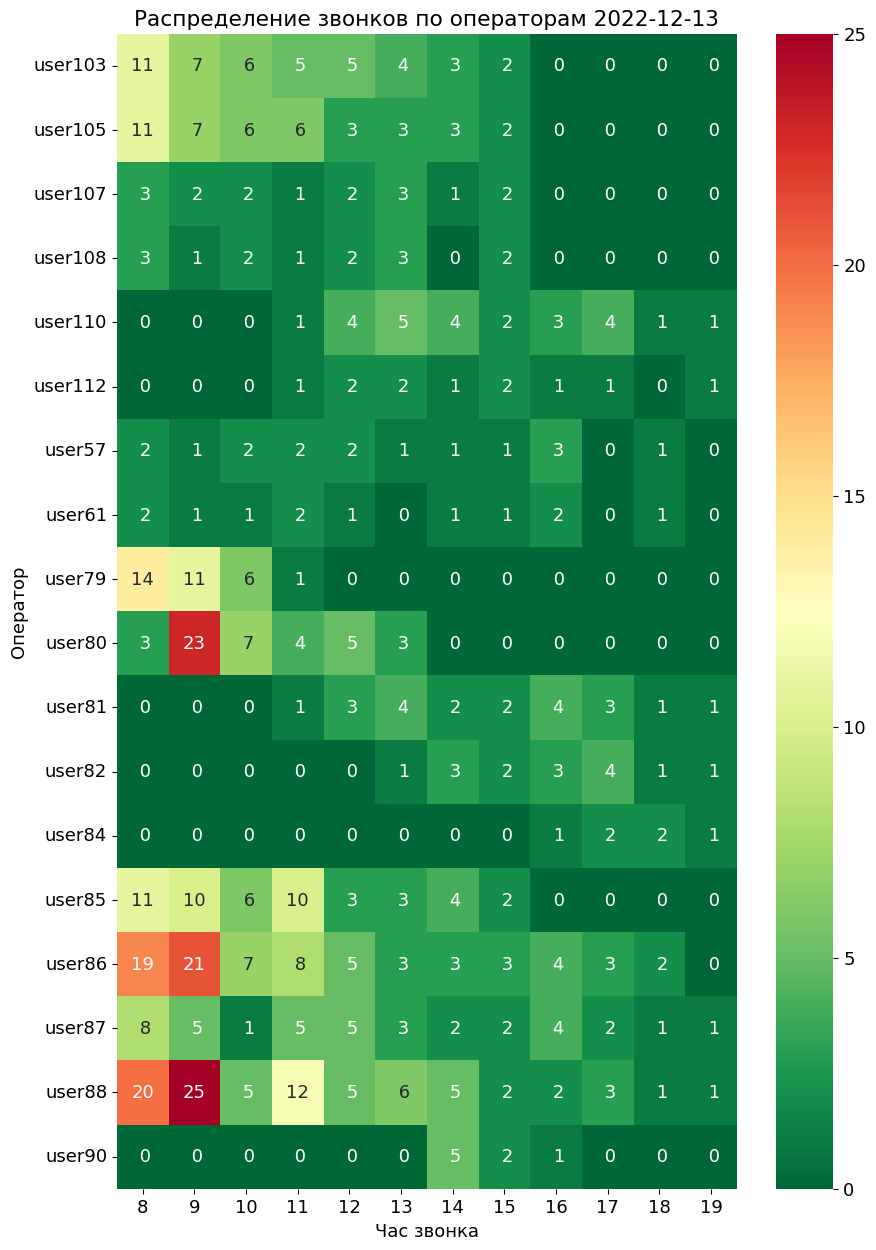

In [72]:
stress_on_oper =  df_specific_day[(df_specific_day['Оператор']!='user8') & (df_specific_day['Оператор']!='user9')& (df_specific_day['Оператор']!='Не определен') & (df_specific_day['Оператор']!='--')]

if check_df_on_none(stress_on_oper):
    f = plt.figure(figsize=(10,15))
    heatmap_plot = sns.heatmap(pd.crosstab(stress_on_oper['Оператор'], stress_on_oper['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="2")
    plt.title('Распределение звонков по операторам '+ str(reporting_date))

    plt.show()

In [73]:
stress_on_oper

,Номер телефона,Время звонка,Статус звонка,Время ожидания,Время разговора,Группа,Оператор,Дата звонка,День недели,Час звонка,Отчетная дата,Ждали,Время ожидания звонка
0,+78443292222,08:00:42,Завершён оператором,0.050000,1.283333,Медколледж,user103,2022-12-13,1,8,2022-12-14,3.0,00:00:03
1,+79093920979,08:00:59,Завершён абонентом,0.050000,2.300000,Медколледж,user85,2022-12-13,1,8,2022-12-14,3.0,00:00:03
2,+79370910967,08:01:12,Завершён оператором,0.416667,0.766667,Медколледж,user87,2022-12-13,1,8,2022-12-14,25.0,00:00:25
3,+79375467939,08:01:34,Завершён абонентом,0.066667,0.733333,Медколледж,user79,2022-12-13,1,8,2022-12-14,4.0,00:00:04
4,+79616798298,08:02:18,Переведён,0.116667,0.283333,Медколледж,user88,2022-12-13,1,8,2022-12-14,7.0,00:00:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,+79047793963,19:17:56,Завершён абонентом,0.133333,2.183333,Медколледж,user110,2022-12-13,1,19,2022-12-14,8.0,00:00:08
555,+79064070134,19:22:50,Завершён оператором,0.050000,4.833333,Мобилизация,user112,2022-12-13,1,19,2022-12-14,3.0,00:00:03
556,+78444245825,19:23:13,Завершён оператором,0.150000,0.216667,Медколледж,user84,2022-12-13,1,19,2022-12-14,9.0,00:00:09
557,+784438443569033,19:27:23,Переведён,0.133333,0.866667,Медколледж,user88,2022-12-13,1,19,2022-12-14,8.0,00:00:08


In [74]:
df_specific_day

,Номер телефона,Время звонка,Статус звонка,Время ожидания,Время разговора,Группа,Оператор,Дата звонка,День недели,Час звонка,Отчетная дата,Ждали,Время ожидания звонка
0,+78443292222,08:00:42,Завершён оператором,0.050000,1.283333,Медколледж,user103,2022-12-13,1,8,2022-12-14,3.0,00:00:03
1,+79093920979,08:00:59,Завершён абонентом,0.050000,2.300000,Медколледж,user85,2022-12-13,1,8,2022-12-14,3.0,00:00:03
2,+79370910967,08:01:12,Завершён оператором,0.416667,0.766667,Медколледж,user87,2022-12-13,1,8,2022-12-14,25.0,00:00:25
3,+79375467939,08:01:34,Завершён абонентом,0.066667,0.733333,Медколледж,user79,2022-12-13,1,8,2022-12-14,4.0,00:00:04
4,+79616798298,08:02:18,Переведён,0.116667,0.283333,Медколледж,user88,2022-12-13,1,8,2022-12-14,7.0,00:00:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,+79047793963,19:17:56,Завершён абонентом,0.133333,2.183333,Медколледж,user110,2022-12-13,1,19,2022-12-14,8.0,00:00:08
555,+79064070134,19:22:50,Завершён оператором,0.050000,4.833333,Мобилизация,user112,2022-12-13,1,19,2022-12-14,3.0,00:00:03
556,+78444245825,19:23:13,Завершён оператором,0.150000,0.216667,Медколледж,user84,2022-12-13,1,19,2022-12-14,9.0,00:00:09
557,+784438443569033,19:27:23,Переведён,0.133333,0.866667,Медколледж,user88,2022-12-13,1,19,2022-12-14,8.0,00:00:08


### Распределение звонков по операторам на первом домене (количественные значения)

In [75]:
stress_on_oper_number1 = stress_on_oper.groupby("Час звонка")["Час звонка"].count().reset_index(name="Число звонков")
# stress_on_oper_number1_tmp = df_specific_day.groupby("Час звонка")["Час звонка"].count().reset_index(name="Число звонков")

# stress_on_oper_number1.join(stress_on_oper_number1, on=None, how='outer')
print(f'Количество звонков {stress_on_oper_number1["Число звонков"].sum()}')
stress_on_oper_number1

Количество звонков 558


,Час звонка,Число звонков
0,8,107
1,9,114
2,10,51
3,11,60
4,12,47
5,13,44
6,14,38
7,15,29
8,16,28
9,17,22


### Распределение звонков по операторам на втором домене (ВМК2)

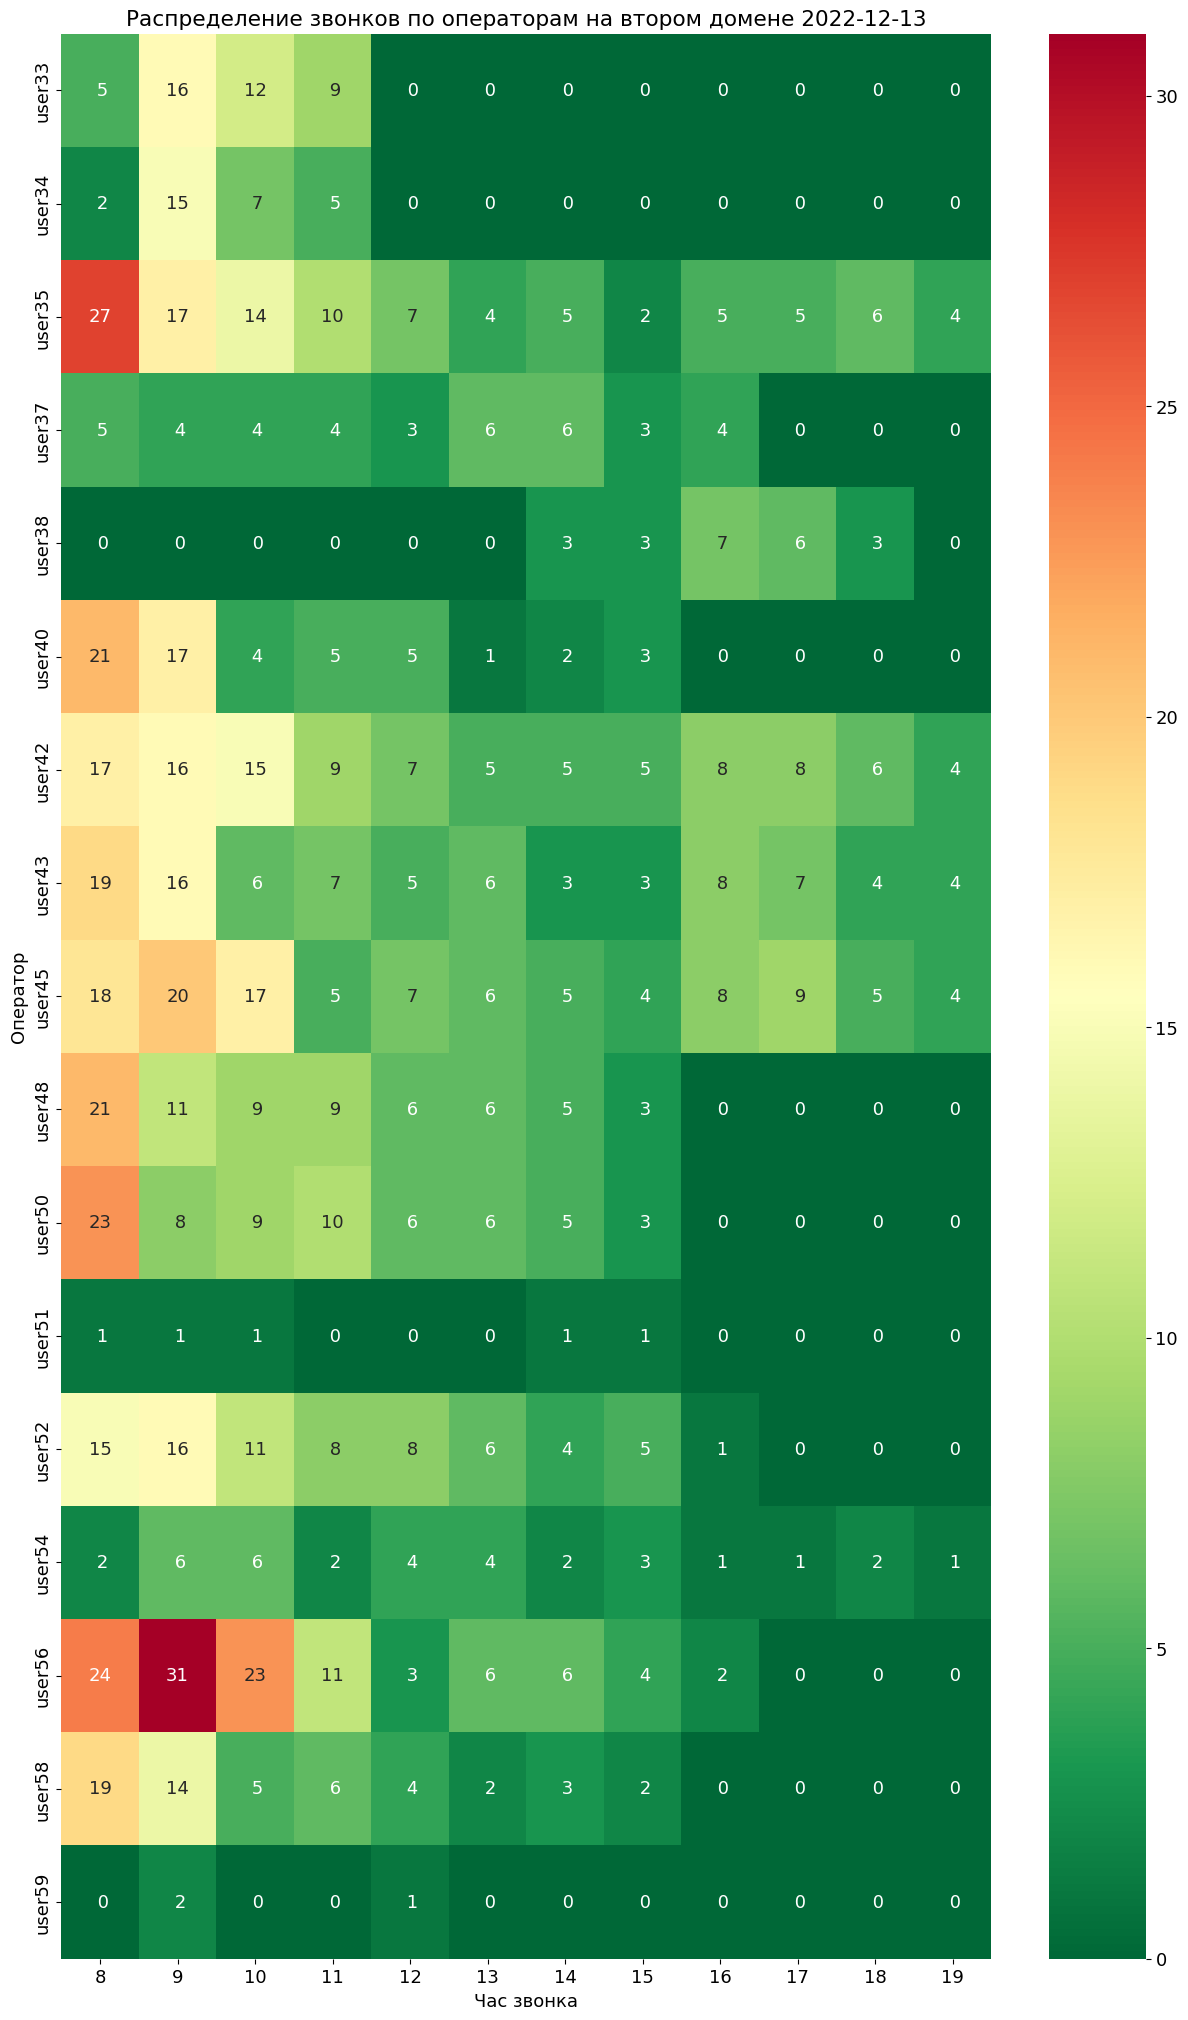

In [76]:
stress_on_oper2 =  df_specific_day2[(df_specific_day2['Оператор']!='user8') & (df_specific_day2['Оператор']!='user9') & (df_specific_day2['Оператор']!='Не определен') & (df_specific_day2['Оператор']!='--')]

if check_df_on_none(stress_on_oper2): 
    f2 = plt.figure(figsize=(15,25))
    heatmap_plot2 = sns.heatmap(pd.crosstab(stress_on_oper2['Оператор'], stress_on_oper2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="2")
    plt.title('Распределение звонков по операторам на втором домене '+ str(reporting_date2))
    plt.show()

### Распределение звонков по операторам на втором домене (ВМК2) (количественные значения)

In [77]:
stress_on_oper_number2 = stress_on_oper2.groupby("Час звонка")["Час звонка"].count().reset_index(name="Число звонков")
print(f'Количество звонков {stress_on_oper_number2["Число звонков"].sum()}')
stress_on_oper_number2

Количество звонков 1018


,Час звонка,Число звонков
0,8,219
1,9,210
2,10,143
3,11,100
4,12,66
5,13,58
6,14,55
7,15,44
8,16,44
9,17,36


### Обшее количество недозвонов по часам за конкретную дату по первому домену (ВМК)

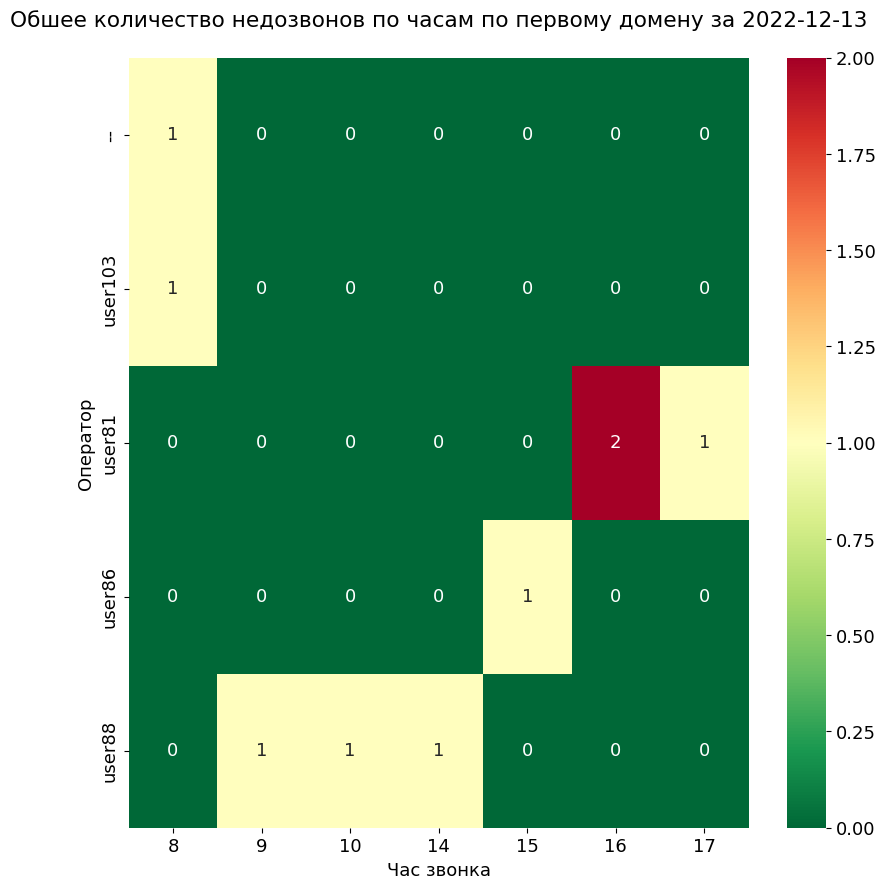

In [78]:
didnot_calls = df_specific_day[(df_specific_day['Оператор'] == '--') | (df_specific_day['Статус звонка'] == 'Не дождался')] 
if check_df_on_none(didnot_calls):   

    if didnot_calls.empty: 
        print("Нет пропущенных звонков на втором домене")         
    else:
        didnot_calls = df_specific_day[(df_specific_day['Оператор'] == '--') | (df_specific_day['Статус звонка'] == 'Не дождался')]

        print_didnot_calls = didnot_calls[['Время звонка', 'Номер телефона', 'Время ожидания звонка', 'Оператор']].copy()
        print_didnot_calls.to_excel(os.path.join(PATH_REPORTS, f"Обшее количество недозвонов по первому домену.xlsx"), index=False)


        f = plt.figure(figsize=(10,10))

        heatmap_plot = sns.heatmap(pd.crosstab(didnot_calls['Оператор'], didnot_calls['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
        plt.title('Обшее количество недозвонов по часам по первому домену за '+ str(reporting_date2) + '\n')

        plt.show()

In [79]:
df_specific_day2

,Номер телефона,Время звонка,Статус звонка,Время ожидания,Время разговора,Группа,Оператор,Дата звонка,День недели,Час звонка,Отчетная дата,Ждали,Время ожидания звонка
0,+79044150029,08:00:14,Завершён абонентом,0.066667,1.416667,Вызов врача,user50,2022-12-13,1,8,2022-12-14,4.0,00:00:04
1,+79197988821,08:00:30,Завершён оператором,0.050000,1.400000,Вызов врача,user48,2022-12-13,1,8,2022-12-14,3.0,00:00:03
2,+79093871916,08:00:39,Завершён оператором,0.200000,2.366667,Вызов врача,user35,2022-12-13,1,8,2022-12-14,12.0,00:00:12
3,+79375467939,08:00:41,Не дождался,0.083333,0.000000,Вызов врача,user35,2022-12-13,1,8,2022-12-14,5.0,00:00:05
4,+79377426260,08:00:43,Завершён оператором,0.100000,2.700000,Вызов врача,user45,2022-12-13,1,8,2022-12-14,6.0,00:00:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,+79053926346,19:36:16,Завершён оператором,0.233333,1.566667,Вызов врача,user42,2022-12-13,1,19,2022-12-14,14.0,00:00:14
1357,+79033709596,19:40:46,Завершён оператором,0.266667,1.983333,Вызов врача,user35,2022-12-13,1,19,2022-12-14,16.0,00:00:16
1358,+78442248808,19:43:03,Завершён оператором,0.300000,2.283333,Вызов врача,user45,2022-12-13,1,19,2022-12-14,18.0,00:00:18
1359,+79375441788,19:48:17,Завершён абонентом,0.250000,1.083333,Вызов врача,user43,2022-12-13,1,19,2022-12-14,15.0,00:00:15


### Обшее количество недозвонов по часам за конкретную дату по второму домену (ВМК2)

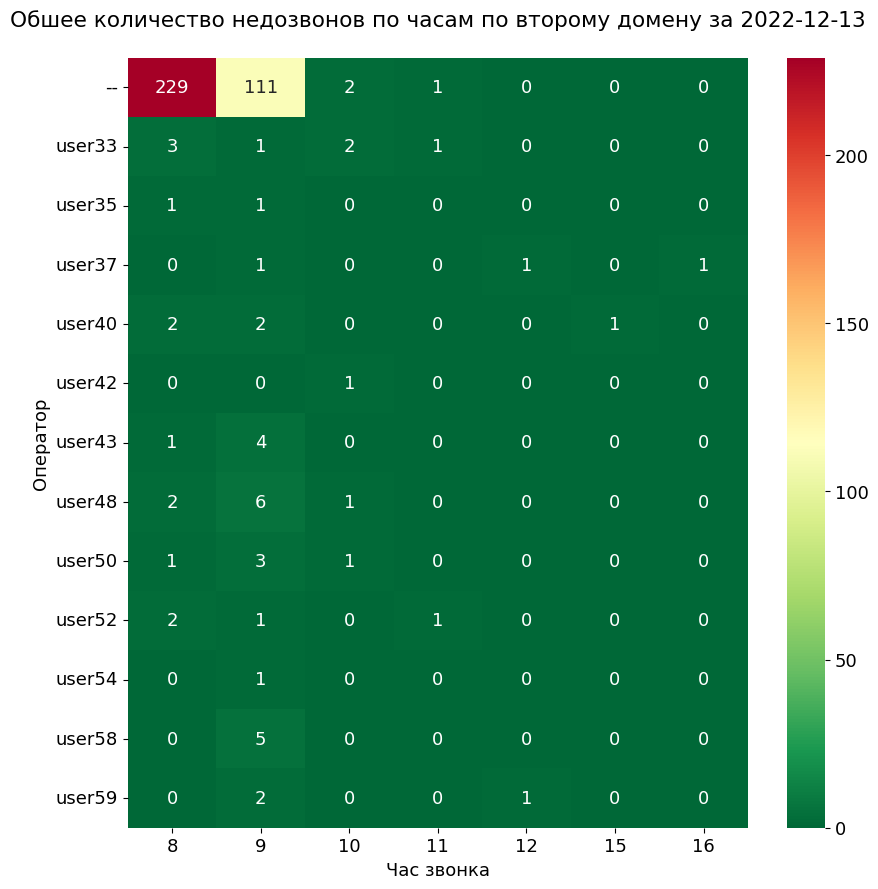

In [80]:
didnot_calls2 = df_specific_day2[(df_specific_day2['Оператор'] == '--') | (df_specific_day2['Статус звонка'] == 'Не дождался')] 
if check_df_on_none(didnot_calls2): 
    if didnot_calls2.empty: 
        print("Нет пропущенных звонков на втором домене")         
    else:    
        print_didnot_calls2 = didnot_calls2[['Время звонка', 'Номер телефона', 'Группа', 'Время ожидания звонка', 'Оператор']].copy() 
        print_didnot_calls2.to_excel(os.path.join(PATH_REPORTS, f"Обшее количество недозвонов по второму домену.xlsx"), index=False) 
        
        f = plt.figure(figsize=(10,10)) 
    
        heatmap_plot = sns.heatmap(pd.crosstab(didnot_calls2['Оператор'], didnot_calls2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1") 
        plt.title('Обшее количество недозвонов по часам по второму домену за '+ str(reporting_date2) + '\n') 
    
        plt.show()

### Распределение звонков по операторам за конкретную дату по первому домену (ВМК)

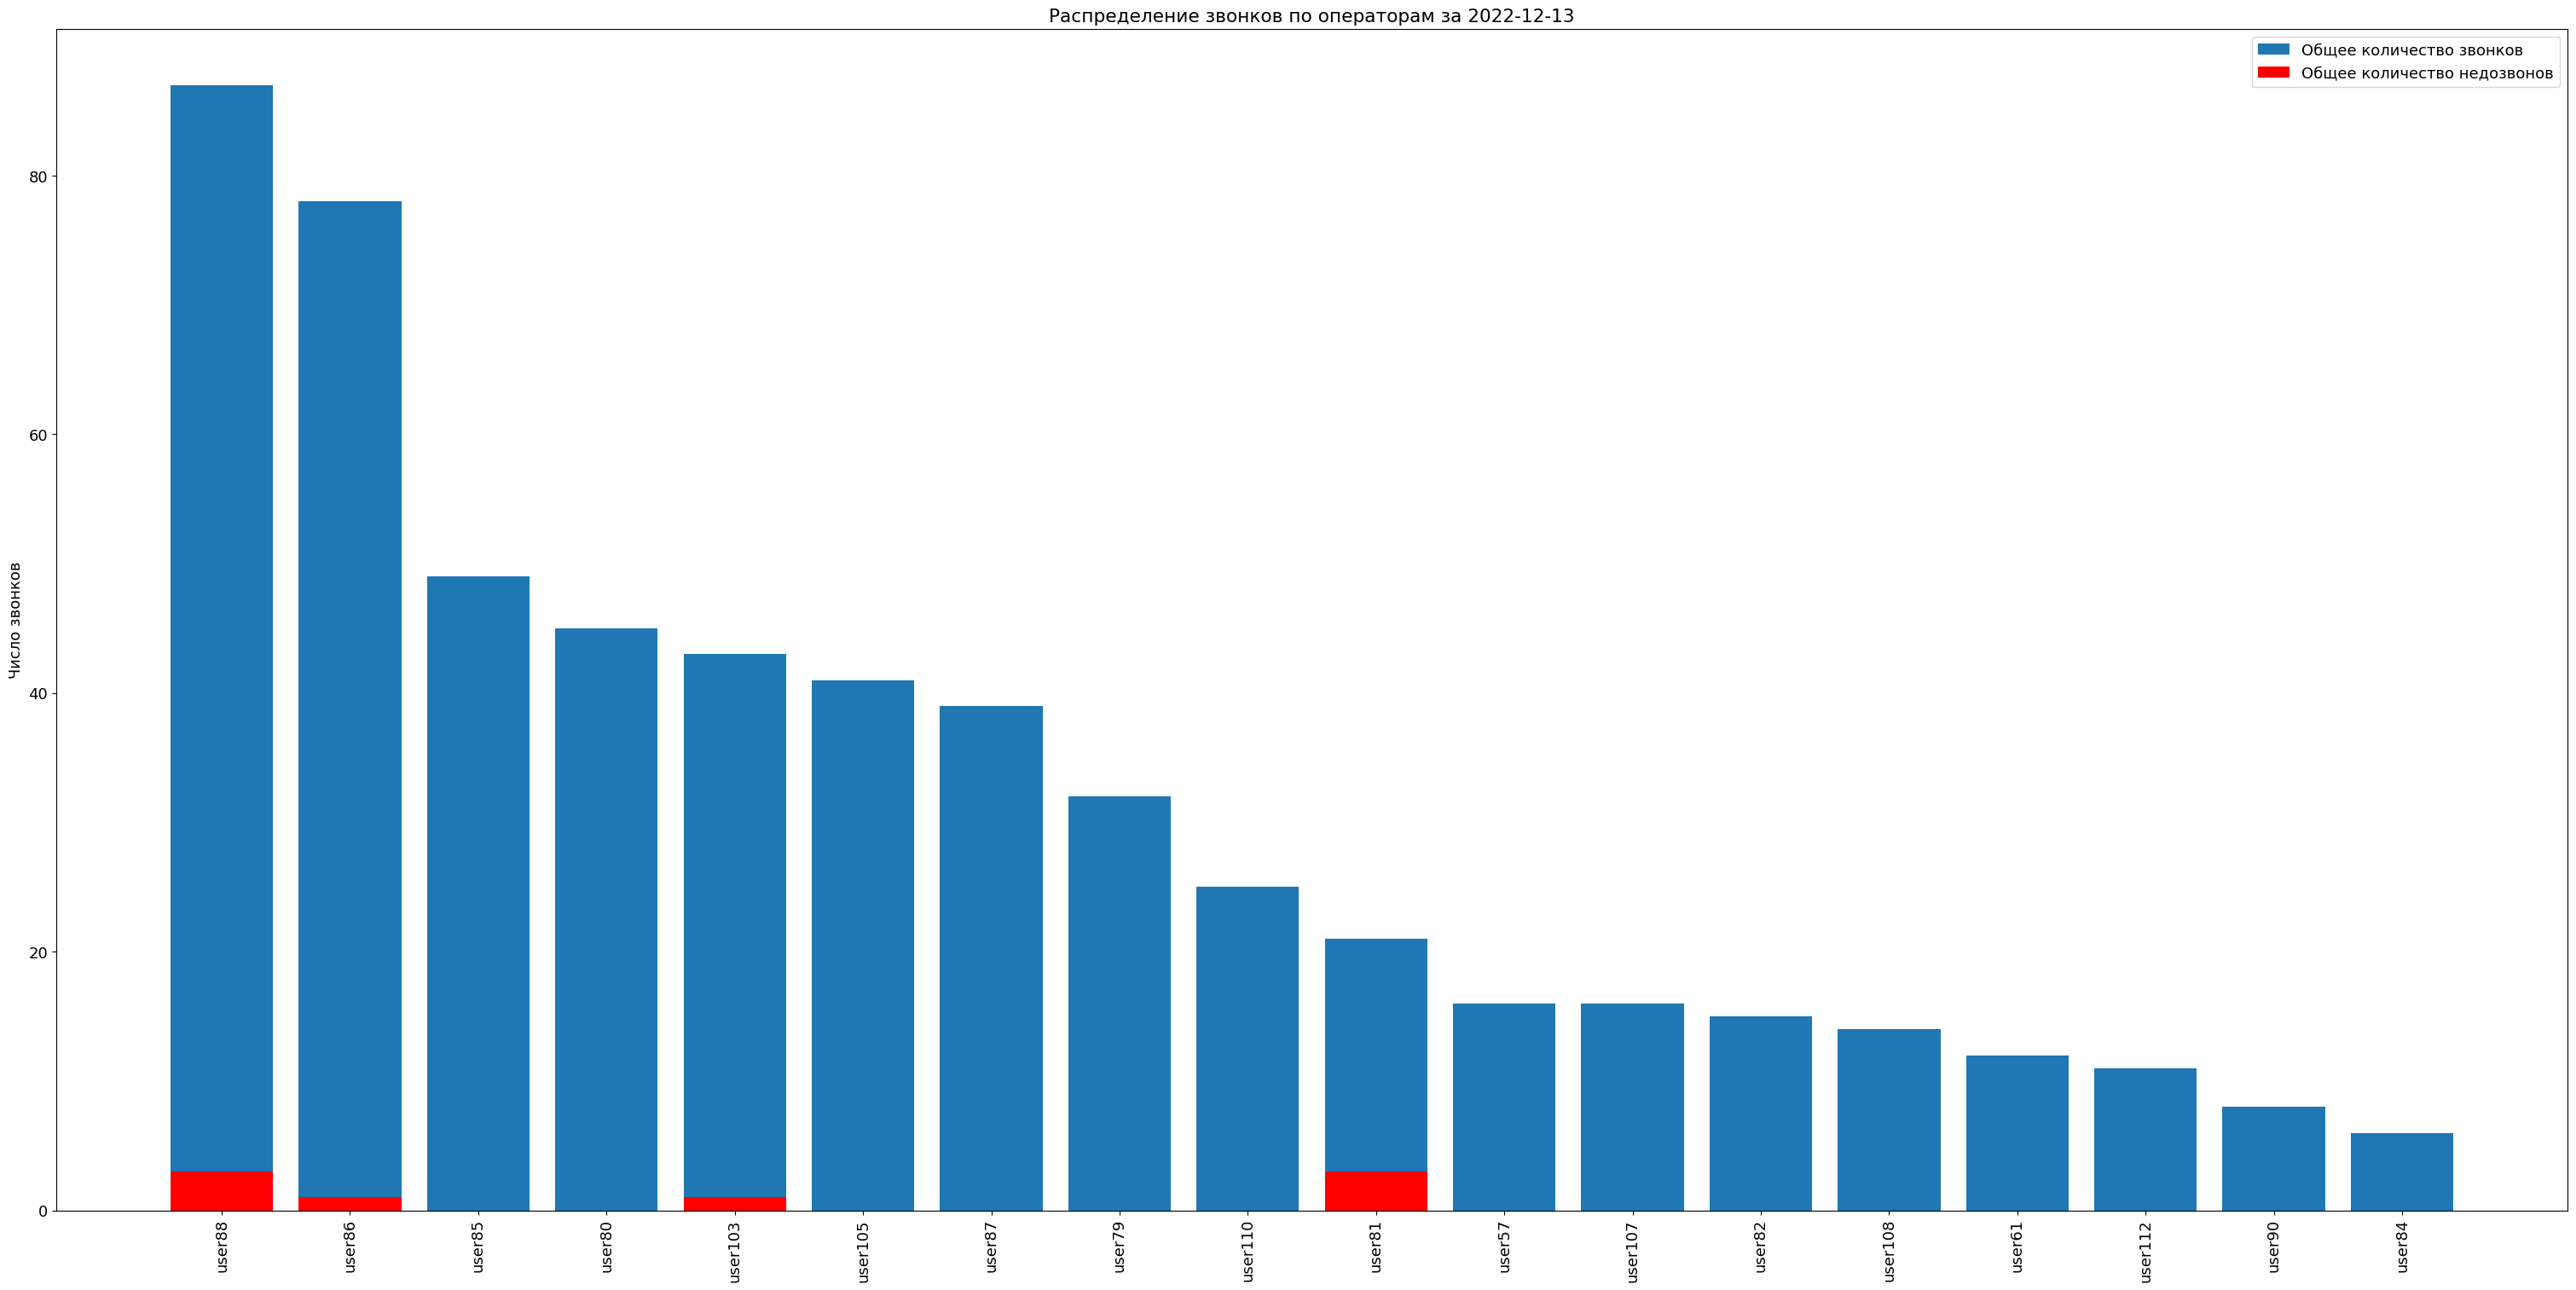

In [81]:
all_calls = stress_on_oper.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

didnot_calls_oper = stress_on_oper[stress_on_oper['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")
if check_df_on_none(didnot_calls_oper):  

    f = plt.figure(figsize=(38,18))
    plt.bar(all_calls['Оператор'], all_calls['Число звонков'],label='Общее количество звонков')
    plt.bar(didnot_calls_oper['Оператор'], didnot_calls_oper['Число звонков'],label='Общее количество недозвонов',color='red')

    plt.ylabel('Число звонков')
    plt.title('Распределение звонков по операторам за '+ str(reporting_date))

    plt.rcParams.update({'font.size': 13})
    plt.gca().xaxis.set_tick_params(rotation = 90) 
    plt.legend()
    plt.show()

### Распределение звонков по операторам за конкретную дату по второму домену (ВМК2)

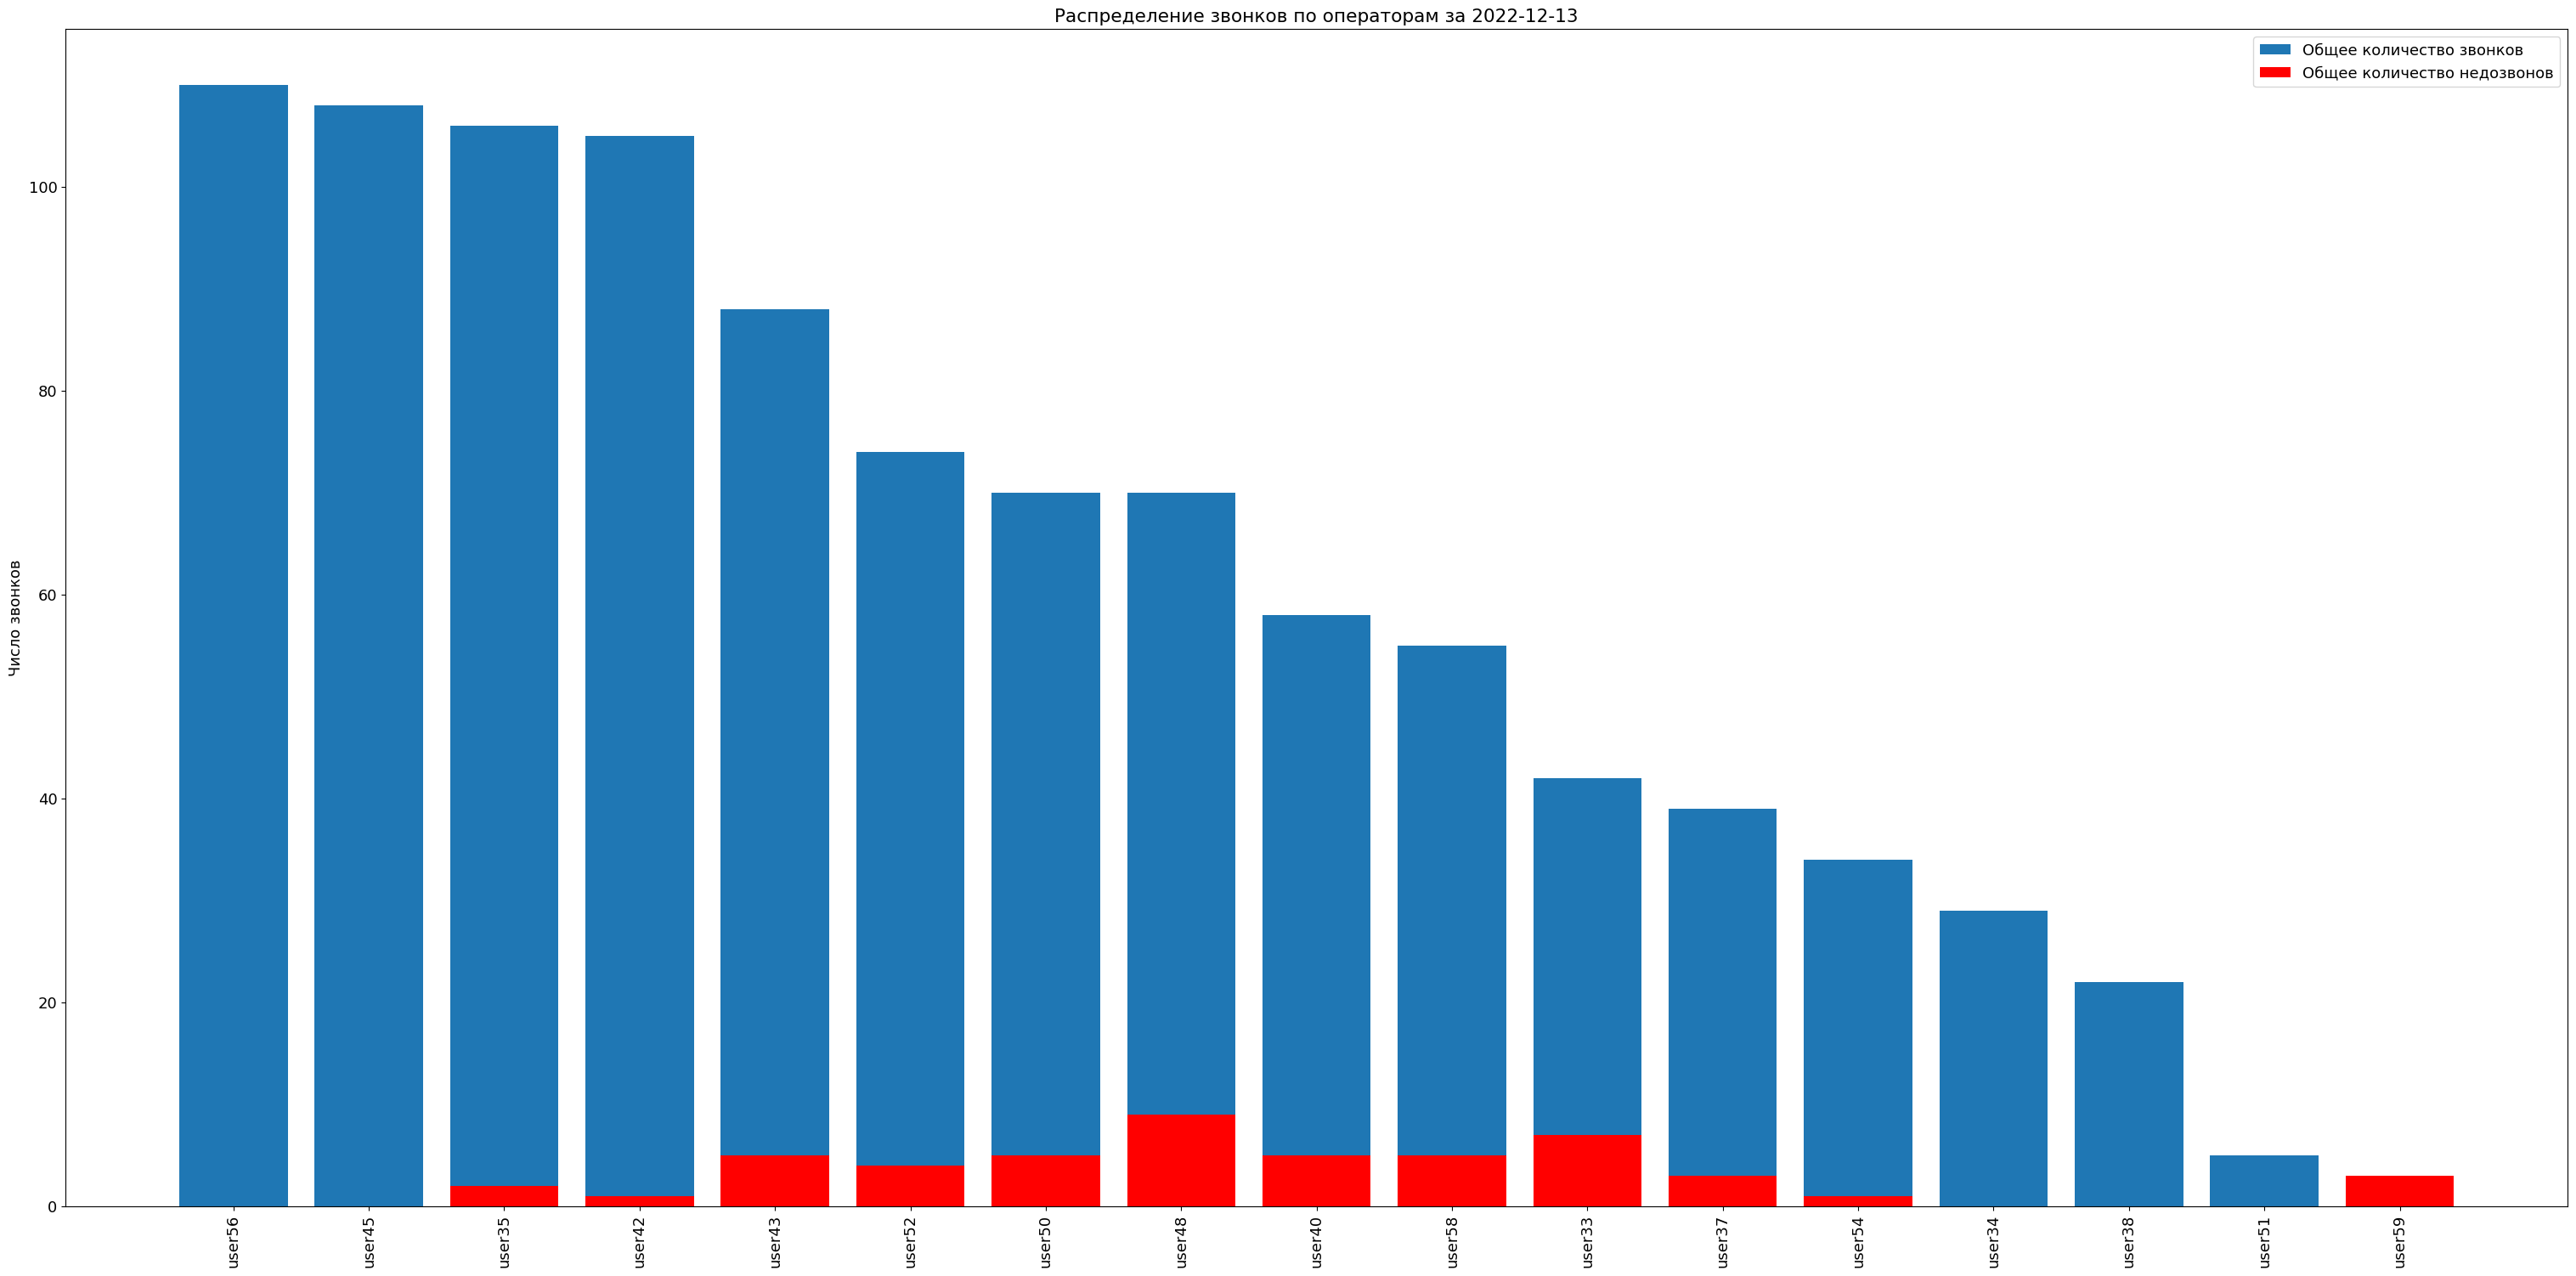

In [82]:
all_calls2 = stress_on_oper2.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

didnot_calls2_oper = stress_on_oper2[stress_on_oper2['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")
if check_df_on_none(didnot_calls2_oper):  

    f = plt.figure(figsize=(38,18))
    plt.bar(all_calls2['Оператор'], all_calls2['Число звонков'],label='Общее количество звонков')
    plt.bar(didnot_calls2_oper['Оператор'], didnot_calls2_oper['Число звонков'],label='Общее количество недозвонов',color='red')

    plt.ylabel('Число звонков')
    plt.title('Распределение звонков по операторам за '+ str(reporting_date2))

    plt.rcParams.update({'font.size': 13})
    plt.gca().xaxis.set_tick_params(rotation = 90) 
    plt.legend()
    plt.show()

### Общее количество звонков на втором домене в разрезе групп на отчётную дату (ВМК2)

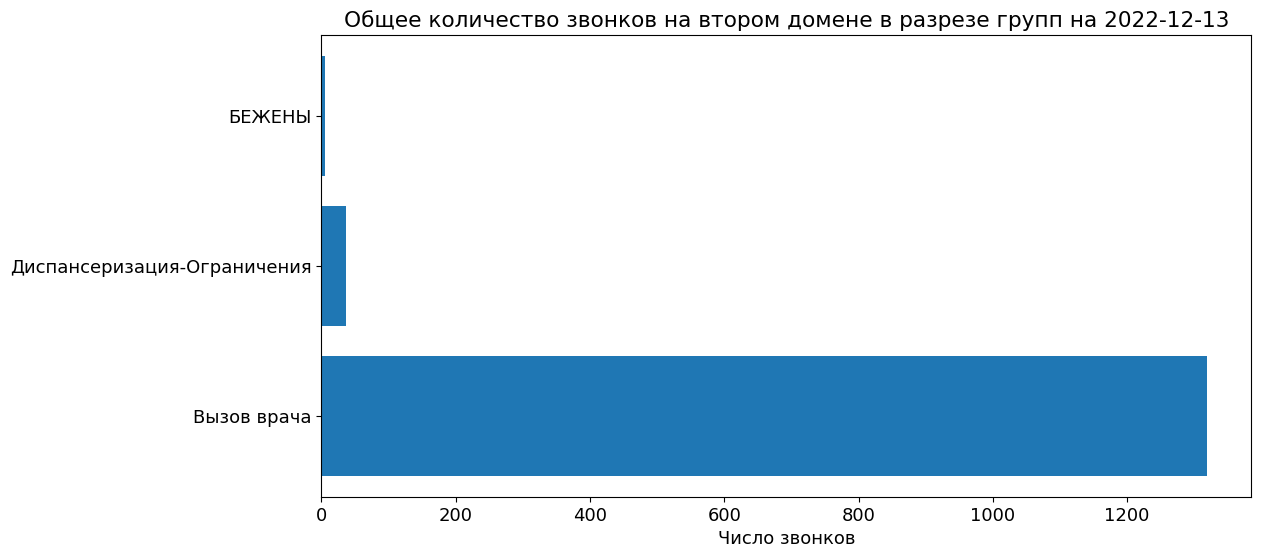

In [83]:
# Общее количество звонков на втором домене в разрезе групп
group_calls2 = df_specific_day2.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)
if check_df_on_none(df_specific_day):

    f = plt.figure(figsize=(12,6))
    plt.barh(group_calls2['Группа'], group_calls2['Число звонков'],label='Общее количество звонков')

    plt.xlabel('Число звонков')
    plt.title(f'Общее количество звонков на втором домене в разрезе групп на {reporting_date2}')

    plt.rcParams.update({'font.size': 13})
    plt.show()

### Общее количество звонков на втором домене в разрезе групп на отчётную дату (Круговая диаграмма) (ВМК2)

Общее количество звонков на втором домене в разрезе групп на 2022-12-13


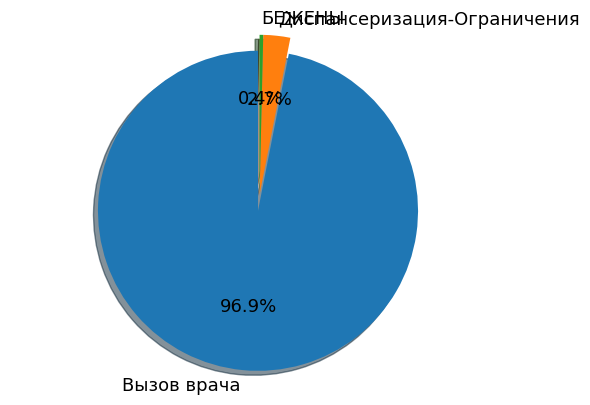

In [84]:
vals = group_calls2['Число звонков']
labels = group_calls2['Группа']
explode = tuple([0.1 if x == 0 else 0 for x in range(len(labels))])
fig, ax = plt.subplots()

ax.pie(vals, labels=labels, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis("equal")
print(f'Общее количество звонков на втором домене в разрезе групп на {reporting_date2}')

### Динамика звонков по часам за конкретную дату на первом домене (ВМК)

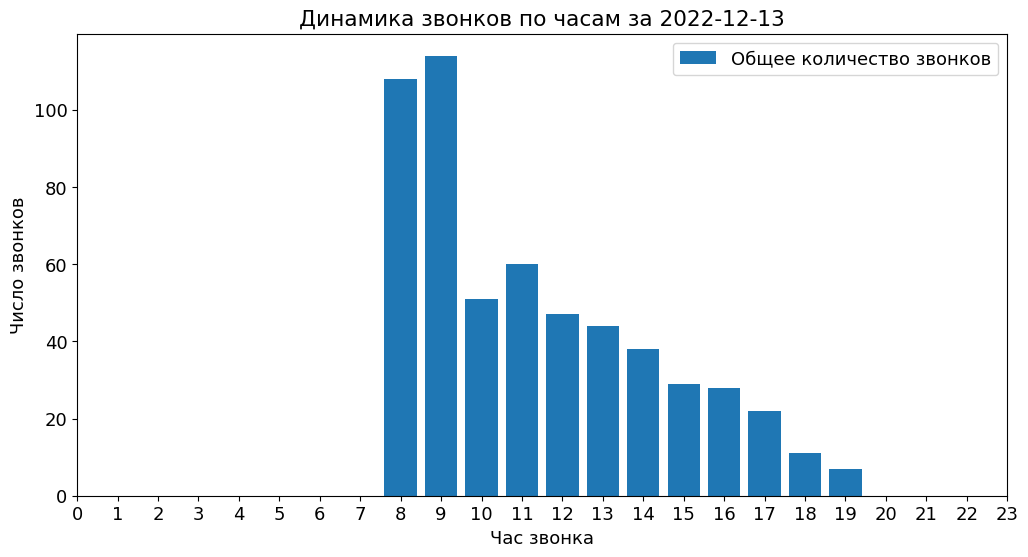

In [85]:
count_calls = df_specific_day.groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
if check_df_on_none(count_calls):

    f = plt.figure(figsize=(12,6))
    plt.bar(count_calls['Час звонка'], count_calls['Число звонков'],label='Общее количество звонков')

    plt.xlabel('Час звонка')
    plt.ylabel('Число звонков')
    plt.title(f'Динамика звонков по часам за {reporting_date}')

    plt.rcParams.update({'font.size': 13})
    plt.xticks(np.arange(0,24,1))
    plt.legend()
    plt.show()

### Динамика звонков по часам за конкретную дату на втором домене (ВМК2)

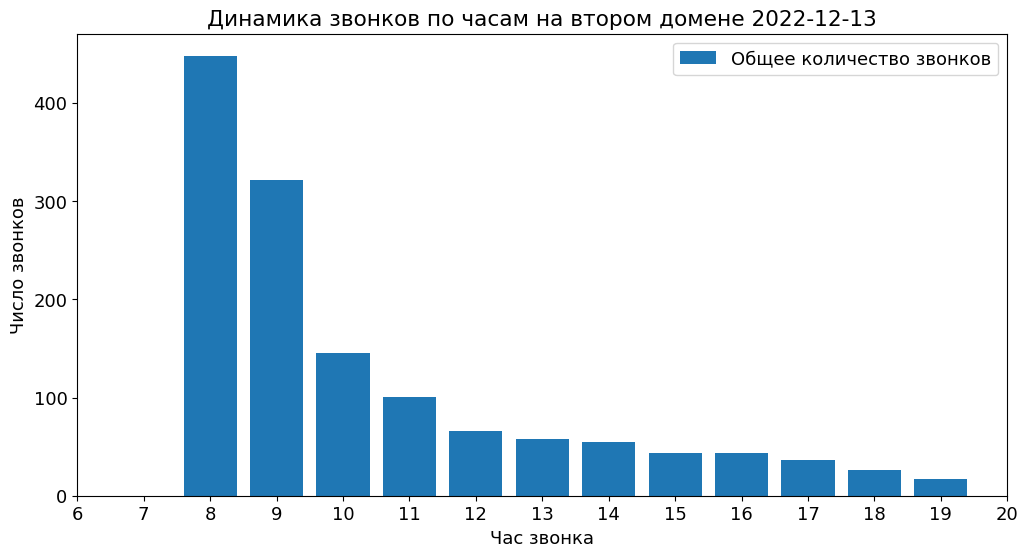

In [86]:
count_calls2 = df_specific_day2.groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
if check_df_on_none(count_calls2):

    f = plt.figure(figsize=(12,6))
    plt.bar(count_calls2['Час звонка'], count_calls2['Число звонков'],label='Общее количество звонков')

    plt.xlabel('Час звонка')
    plt.ylabel('Число звонков')
    plt.title(f'Динамика звонков по часам на втором домене {reporting_date2}')

    plt.rcParams.update({'font.size': 13})
    plt.xticks(np.arange(6,21,1))
    plt.legend()
    plt.show()

# РОСТЕЛЕКОМ первый домен (все группы)

### Считаем статистику по первому домену

In [87]:
calculate_statistics_WMK(df_specific_day)
calculate_statistics_RT(df_specific_day_RT)
print(f"\nСтатистика по частичной мобилизации в РФ (по номеру 122) за {DAY_STATICTICS_CALCULATION_VMK1.strftime('%d.%m.%Y')} на {dt.datetime.now().strftime('%H:%M')}")
print_calculate_statistics_VMK_mob(calculate_values_for_report_vmk(df=df_specific_day_mob))

print("\n\n", df_specific_day_RT)
#total_all_days_RT[(total_all_days_RT['Номер вызываемого']=='78442325552') & (total_all_days_RT['Дата вызова']==dayRT) & (total_all_days_RT['Статус']=='пропущенный')]

table_RT = df_specific_day_RT[(df_specific_day_RT['Номер вызываемого']=='78442325552') & (df_specific_day_RT['Дата вызова']==dayRT) & (df_specific_day_RT['Статус']=='пропущенный')]
table_RT['Длительность'] = table_RT['Длительность'].apply(lambda value: round(value / 60, 1))
table_RT['Дата вызова']  = table_RT['Дата вызова'].apply(lambda value: value.strftime('%d.%m.%Y'))
table_RT.to_excel(os.path.join(PATH_REPORTS, "Неотвеченные.xlsx"), index=False)


Информация по вызовам по состоянию на 15:00 за 13.12.2022.
Максимальное время ожидания за сутки (мин): 0.8 (Оператор: user105, Группа: Медколледж, Время звонка: 14:02:43))
            
По выгрузке Ростелекома: неотвеченных вызовов - 0.0 %
Всего вызовов – 1762, неотвеченных – 0 (отфильтровано менее 120 сек, а также по группе "Не определена").

Статистика по частичной мобилизации в РФ (по номеру 122) за 13.12.2022 на 15:00
1. Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации: 69
2. SL за 10 сек., %: 98.55
3. Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации: 0.3
4. Среднее время ожидания на линии консультаций по вопросам частичной мобилизации: 0.1
5. Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации: 2.2


      Дата вызова Время вызова Номер вызывающего Номер вызываемого Оператор  \
0     2022-12-13     19:52:45      +79054152056       78442325552   user25   
1     2022-12-13   

### Данные о мобилизации (ВМК + Ростелеком)

In [88]:
if check_df_on_none(df_specific_day_mob):
    dict_values_for_report_mob_vmk = calculate_values_for_report_vmk(df_specific_day_mob)

    print(f"   Статистика по частичной мобилизации в РФ (по номеру 122) за {DAY_STATICTICS_CALCULATION_VMK1.strftime('%d.%m.%Y')}")
    print_calculate_statistics_VMK_mob(dict_values_for_report_mob_vmk)

    df_specific_day_mob_report_columns='Отчетная дата	Субъект РФ	Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации	SL за10 сек., %	Количество потерянных вызовов на линии консультаций по вопросам частичной мобилизации	Процент потерянных вызовов на линии консультаций по вопросам частичной мобилизации, %	Количество потерянных вызовов с уникальных абонентских номеров на линии консультаций по вопросам частичной мобилизации	Количество успешных обратных звонков недозвонившимся пользователям	Процент пользователей, которым не осуществлён обратный успешный звонок	Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации, мин	Среднее время ожидания на линии консультаций по вопросам частичной мобилизации, мин.	Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации, мин	Число вызовов поступивших на линию консультаций по вопросам частичной мобилизации в нерабочее время (для КЦ не имеющих круглосуточные смены обслуживания)	Наличие круглосуточной смены обслуживания линии консультаций по вопросам частичной мобилизации	Используемая операторами 122 версия (дата) скрипта для консультаций по вопросам частичной мобилизации	Количество операторов занятых на обслуживании линии консультаций по вопросам частичной мобилизации'.split("\t")

    # Дополнительные расчеты по DataFrame - table_RT
    table_RT_mobiliz = table_RT[table_RT['Группа'] == 'кнопка 1']
    unique_phone_number_table_RT_mobiliz = table_RT_mobiliz.drop_duplicates(subset='Номер вызывающего')

    number_unanswered_call = table_RT_mobiliz.shape[0]
    number_unique_unanswered_call = unique_phone_number_table_RT_mobiliz.shape[0]

    # Создание результирующей таблицы
    df_specific_day_mob_report = pd.DataFrame([[DAY_STATICTICS_CALCULATION_VMK1.strftime("%d.%m.%Y"), 'Волгоградская область', 
    dict_values_for_report_mob_vmk.get('total_number_calls'), dict_values_for_report_mob_vmk.get('SL_for_10_minutes'), 
    number_unanswered_call, round(number_unanswered_call / dict_values_for_report_mob_vmk.get('total_number_calls') * 100, 2),
    number_unique_unanswered_call, number_unique_unanswered_call, 0.0, 
    dict_values_for_report_mob_vmk.get('max_time_wait_call'), dict_values_for_report_mob_vmk.get('mean_time_wait_call'), 
    dict_values_for_report_mob_vmk.get('mean_time_talked_on_phone'), 0, 'да', 
    DAY_STATICTICS_CALCULATION_VMK1.strftime("%d.%m.%Y"), 51]], columns=df_specific_day_mob_report_columns)

    df_specific_day_mob_report.to_excel(os.path.join(PATH_REPORTS,"Инструкция_ЧМ_Волгоградская_область.xlsx"), index=False)
    display(HTML(df_specific_day_mob_report.to_html()))

   Статистика по частичной мобилизации в РФ (по номеру 122) за 13.12.2022
1. Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации: 69
2. SL за 10 сек., %: 98.55
3. Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации: 0.3
4. Среднее время ожидания на линии консультаций по вопросам частичной мобилизации: 0.1
5. Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации: 2.2


,Отчетная дата,Субъект РФ,Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации,"SL за10 сек., %",Количество потерянных вызовов на линии консультаций по вопросам частичной мобилизации,"Процент потерянных вызовов на линии консультаций по вопросам частичной мобилизации, %",Количество потерянных вызовов с уникальных абонентских номеров на линии консультаций по вопросам частичной мобилизации,Количество успешных обратных звонков недозвонившимся пользователям,"Процент пользователей, которым не осуществлён обратный успешный звонок","Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации, мин","Среднее время ожидания на линии консультаций по вопросам частичной мобилизации, мин.","Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации, мин",Число вызовов поступивших на линию консультаций по вопросам частичной мобилизации в нерабочее время (для КЦ не имеющих круглосуточные смены обслуживания),Наличие круглосуточной смены обслуживания линии консультаций по вопросам частичной мобилизации,Используемая операторами 122 версия (дата) скрипта для консультаций по вопросам частичной мобилизации,Количество операторов занятых на обслуживании линии консультаций по вопросам частичной мобилизации
0,13.12.2022,Волгоградская область,69,98.55,0,0.0,0,0,0.0,0.3,0.1,2.2,0,да,13.12.2022,51


## Считаем статистику по первому домену c 8:00 по 23:59 текущего дня и с 00:00 до 8:00 следующего дня

In [89]:
current_day = DAY_STATICTICS_CALCULATION_FROM_8_to_8

df_specific_vmk_1 = pd.concat([load_one_table(path_storage=PATH_VMK, day_statictics_calculation=(current_day + dt.timedelta(1)), 
                                start_hour_job=8, end_hour_job=24, is_VMK=True), load_one_table(path_storage=PATH_VMK, 
                                day_statictics_calculation=(current_day + dt.timedelta(2)), 
                                start_hour_job=0, end_hour_job=8, is_VMK=True)], ignore_index=True)

df_specific_rt_1 = pd.concat([load_one_table(path_storage=PATH_ROSTELECOM, day_statictics_calculation=current_day, 
                                start_hour_job=8, end_hour_job=24), load_one_table(path_storage=PATH_ROSTELECOM, 
                                day_statictics_calculation=(current_day + dt.timedelta(1)), 
                                start_hour_job=0, end_hour_job=8)],  ignore_index=True)

calculate_statistics_WMK(df_specific_vmk_1, report_one_day=False)
calculate_statistics_RT(df_specific_rt_1)
print()
print_calculate_statistics_VMK_mob(calculate_values_for_report_vmk(df=df_specific_vmk_1[df_specific_vmk_1["Группа"] == "Мобилизация"]))


Информация по вызовам по состоянию с 8:00 29.10.2022 по 8:00 30.10.2022.
Максимальное время ожидания за сутки (мин): 5.4 (Оператор: user86, Группа: Медколледж, Время звонка: 17:12:01))
            
По выгрузке Ростелекома: неотвеченных вызовов - 1.56 %
Всего вызовов – 385, неотвеченных – 6 (отфильтровано менее 120 сек, а также по группе "Не определена").

1. Количество входящих вызовов на линию консультаций по вопросам частичной мобилизации: 238
2. SL за 10 сек., %: 92.86
3. Максимальное время ожидания на линии консультаций по вопросам частичной мобилизации: 2.2
4. Среднее время ожидания на линии консультаций по вопросам частичной мобилизации: 0.1
5. Среднее время обслуживания вызовов на линии консультаций по вопросам частичной мобилизации: 2.0


### Отчет по максимальному времени ожидания c 8:00 по 23:59 текущего дня и с 00:00 до 8:00 следующего дня

In [90]:
if check_df_on_none(df_specific_vmk_1): 
    table_max_time_wait_calls_RT = table_waiting_time(df_specific_vmk_1).head(20)
    table_max_time_wait_calls_RT.reset_index(inplace=True, drop=True)
    table_max_time_wait_calls_RT['Дата звонка']  = table_max_time_wait_calls_RT['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
    table_max_time_wait_calls_RT.to_excel(os.path.join(PATH_REPORTS, f"Отчет по макс. времени ожидания c 8_00 по 23_59 текущего дня и с 00_00 до 8_00 следущего (ВМК).xlsx"), index=False)
    display(HTML(table_max_time_wait_calls_RT.to_html()))

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
0,29.10.2022,7.995696e+10,17:12:01,00:05:22,Медколледж,user86,Завершён оператором
1,29.10.2022,7.960883e+10,18:52:17,00:04:14,Медколледж,user84,Завершён абонентом
2,29.10.2022,7.961680e+10,11:35:48,00:02:47,Медколледж,user86,Переведён
3,29.10.2022,7.905063e+10,17:11:18,00:02:44,Медколледж,--,Не дождался
4,29.10.2022,7.844241e+10,11:23:48,00:02:38,Медколледж,--,Не дождался
5,30.10.2022,7.969285e+10,05:34:24,00:02:15,Мобилизация,user57,Завершён оператором
6,29.10.2022,7.844241e+10,11:27:39,00:02:11,Медколледж,--,Не дождался
7,29.10.2022,7.844220e+10,11:24:17,00:01:57,Медколледж,--,Не дождался
8,29.10.2022,7.904421e+10,13:53:46,00:01:56,Медколледж,user88,Завершён оператором
9,29.10.2022,7.927256e+10,15:39:07,00:01:52,Медколледж,user86,Завершён абонентом


### Отчет по неотвеченным c 8:00 по 23:59 текущего дня и с 00:00 до 8:00 следующего дня

In [91]:
if check_df_on_none(df_specific_rt_1):
    table_unanswered_calls_RT = df_specific_rt_1[(df_specific_rt_1['Номер вызываемого']== '78442325552') & (df_specific_rt_1['Статус'] == 'пропущенный')]
    table_unanswered_calls_RT.reset_index(inplace=True, drop=True)
    table_unanswered_calls_RT['Дата вызова']  = table_unanswered_calls_RT['Дата вызова'].apply(lambda value: value.strftime('%d.%m.%Y'))
    table_unanswered_calls_RT['Длительность'] = table_unanswered_calls_RT['Длительность'].apply(lambda value: round(value / 60, 1)) 
    table_unanswered_calls_RT.to_excel(os.path.join(PATH_REPORTS, "Неотвеченные c 8_00 по 23_59 текущего дня и с 00_00 до 8_00 следующего дня.xlsx"), index=False)
    display(HTML(table_unanswered_calls_RT.to_html()))

C:\Users\Admin\AppData\Local\Temp\ipykernel_16156\3167304028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_unanswered_calls_RT['Дата вызова']  = table_unanswered_calls_RT['Дата вызова'].apply(lambda value: value.strftime('%d.%m.%Y'))
C:\Users\Admin\AppData\Local\Temp\ipykernel_16156\3167304028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_unanswered_calls_RT['Длительность'] = table_unanswered_calls_RT['Длительность'].apply(lambda value: round(value / 60, 1))


,Дата вызова,Время вызова,Номер вызывающего,Номер вызываемого,Оператор,Статус,Длительность,Группа,День недели,Час звонка,Наименование учреждения,Единый номер,Поставшик услуг
0,29.10.2022,19:50:06,+79960023497,78442325552,Не определен,пропущенный,2.2,Медколледж,5,19,NaN,NaN,NaN
1,29.10.2022,17:10:26,+79050629508,78442325552,Не определен,пропущенный,3.6,Медколледж,5,17,NaN,NaN,NaN
2,29.10.2022,15:39:07,+79876523725,78442325552,Не определен,пропущенный,2.2,Медколледж,5,15,NaN,NaN,NaN
3,29.10.2022,11:26:46,+78442412660,78442325552,Не определен,пропущенный,3.0,Медколледж,5,11,NaN,NaN,NaN
4,29.10.2022,11:23:29,+78442201008,78442325552,Не определен,пропущенный,2.7,Медколледж,5,11,ГУЗ «Детская поликлиника № 6»,+78442201008,"ООО ""Манго Телеком"""
5,29.10.2022,11:22:55,+78442412660,78442325552,Не определен,пропущенный,3.5,Медколледж,5,11,NaN,NaN,NaN


# СЦ МКС (здрав)

### Считаем статистику для СЦ МКС по первому домену (ВМК) 

In [92]:
calculate_statistics(df_specific_day_for_medical,'Данные по первому домену')

Данные по первому домену
за 2022-12-13

Информация за сутки: 

Число операторов всего: 13,
Всего звонков 490, неотвеченных вызовов: 9
Среднее время разговора за сутки (мин): 1.7
Максимальное время ожидания за сутки (мин): 0.8 (Оператор: user105, Группа: Медколледж, Время звонка: 14:02:43)
Среднее время ожидания за сутки(мин): 0.08364
Ожидание более 3 минут за сутки (%): 0.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 13, из них 13 отвечали на звонки
Днем позвонили 490 раз, из них неотвеченных вызовов: 9
Среднее время разговора денём (мин): 1.7
Максимальное время ожидания днём (мин): 0.8 (Оператор: user105, Группа: Медколледж, Время звонка: 14:02:43)
Среднее время ожидания днём (мин): 0.08364
Ожидание более 3 минут днём (%): 0.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 0, из них 0 отвечали на звонки
Ночью позвонили 0 раз, из них неотвеченных вызовов: 0
Среднее время разговора ночью (мин): nan
Максимальное время ожида

### Отчет по максимальному времени ожидания СЦ МКС

In [93]:
if check_df_on_none(df_specific_day_for_medical): 
    report_CS_MKS_max_time_wait_calls_vmk = table_waiting_time(df_specific_day_for_medical).head(20)
    report_CS_MKS_max_time_wait_calls_vmk.reset_index(inplace=True, drop=True)
    report_CS_MKS_max_time_wait_calls_vmk['Дата звонка']  = report_CS_MKS_max_time_wait_calls_vmk['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
    report_CS_MKS_max_time_wait_calls_vmk.to_excel(os.path.join(PATH_REPORTS, f"Отчет по максимальному времени ожидания для СЦ МКС (ВМК).xlsx"), index=False)
    display(HTML(report_CS_MKS_max_time_wait_calls_vmk.to_html()))

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
0,13.12.2022,+78442248808,14:02:43,00:00:45,Медколледж,user105,Завершён абонентом
1,13.12.2022,+79996568716,09:30:31,00:00:37,Медколледж,user88,Не дождался
2,13.12.2022,+78442717540,09:16:19,00:00:31,Медколледж,user88,Переведён
3,13.12.2022,+78442591089,08:03:31,00:00:28,Медколледж,user86,Завершён оператором
4,13.12.2022,+79370910967,08:01:12,00:00:25,Медколледж,user87,Завершён оператором
5,13.12.2022,+78442380285,11:51:23,00:00:25,Медколледж,user110,Завершён оператором
6,13.12.2022,+79889642766,08:03:46,00:00:23,Медколледж,user86,Завершён оператором
7,13.12.2022,+78442248808,14:08:22,00:00:19,Медколледж,user82,Завершён абонентом
8,13.12.2022,+78442525533,14:07:41,00:00:15,Медколледж,user90,Переведён
9,13.12.2022,+79692877594,16:03:33,00:00:14,Медколледж,user87,Завершён оператором


### Отчет по неотвеченным звонкам СЦ МКС

In [94]:
table_unanswered_call_RT = table_RT.drop(table_RT[table_RT['Группа'] == 'кнопка 1'].index)

if check_df_on_none(df_specific_day_for_medical): 
    table_unanswered_call_RT.reset_index(inplace=True, drop=True)
    table_unanswered_call_RT.to_excel(os.path.join(PATH_REPORTS, "Неотвеченные СЦ МКС.xlsx"), index=False)
    display(HTML(table_unanswered_call_RT.to_html()))

,Дата вызова,Время вызова,Номер вызывающего,Номер вызываемого,Оператор,Статус,Длительность,Группа,День недели,Час звонка,Наименование учреждения,Единый номер,Поставшик услуг


### Статистика для СЦ МКС

In [95]:
calculate_statistics_WMK(df_specific_day_for_medical)
calculate_statistics_RT(df_specific_day_RT_for_medical)


Информация по вызовам по состоянию на 15:00 за 13.12.2022.
Максимальное время ожидания за сутки (мин): 0.8 (Оператор: user105, Группа: Медколледж, Время звонка: 14:02:43))
            
По выгрузке Ростелекома: неотвеченных вызовов - 0.0 %
Всего вызовов – 1692, неотвеченных – 0 (отфильтровано менее 120 сек, а также по группе "Не определена").


# Ростелеком (все группы)

### Распределение звонков по операторам

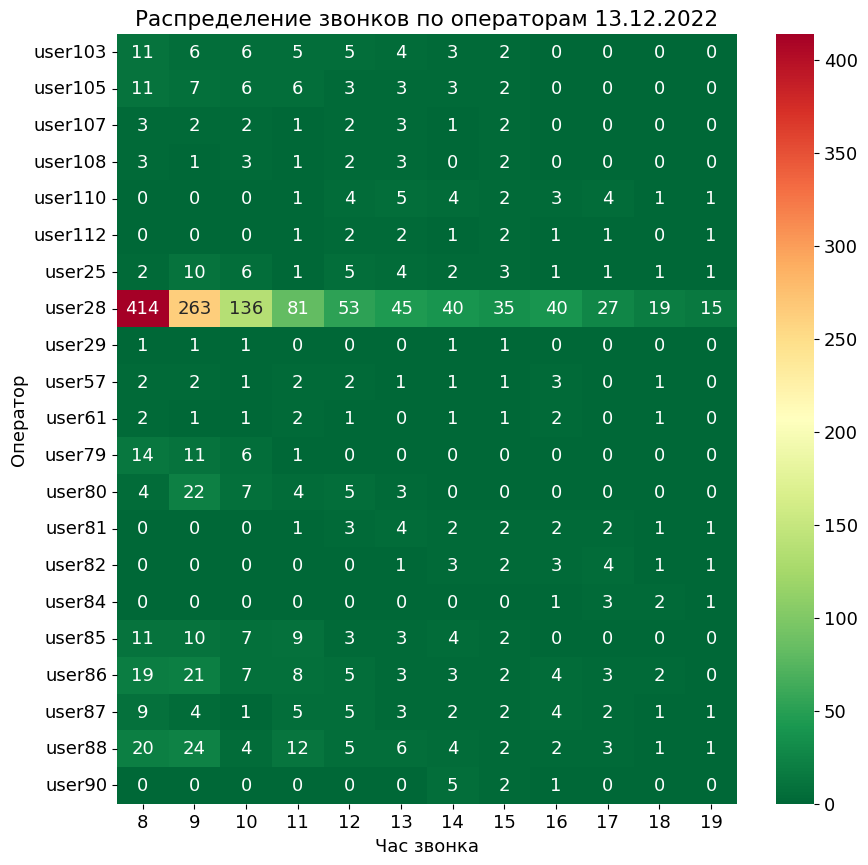

In [96]:
################################################################################################
tmp = df_specific_day_RT[(df_specific_day_RT['Номер вызываемого'] =='78442325552') & (df_specific_day_RT['Оператор']!='user8') & (df_specific_day_RT['Оператор']!='user9')]

if check_df_on_none(tmp):
    f = plt.figure(figsize=(10,10))
    heatmap_plot = sns.heatmap(pd.crosstab(tmp['Оператор'], tmp['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
    plt.title('Распределение звонков по операторам '+ DAY_STATICTICS_CALCULATION_ROSTELECOM.strftime('%d.%m.%Y'))

    plt.show()

### Обшее количество недозвонов по часам

In [97]:
if tmp[tmp['Оператор']=='Не определен'].empty:
    print("Нет пропущенных звонков")        
else:        
    temp2 = tmp[tmp['Оператор']=='Не определен']
    f = plt.figure(figsize=(10,1))
    heatmap_plot = sns.heatmap(pd.crosstab(temp2['Оператор'], temp2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
    plt.title('Обшее количество недозвонов по часам за '+ DAY_STATICTICS_CALCULATION_ROSTELECOM.strftime('%d.%m.%Y' + '\n'))
    plt.show('Не определен')

Нет пропущенных звонков


### Общее количество звонков на первом домене в разрезе групп

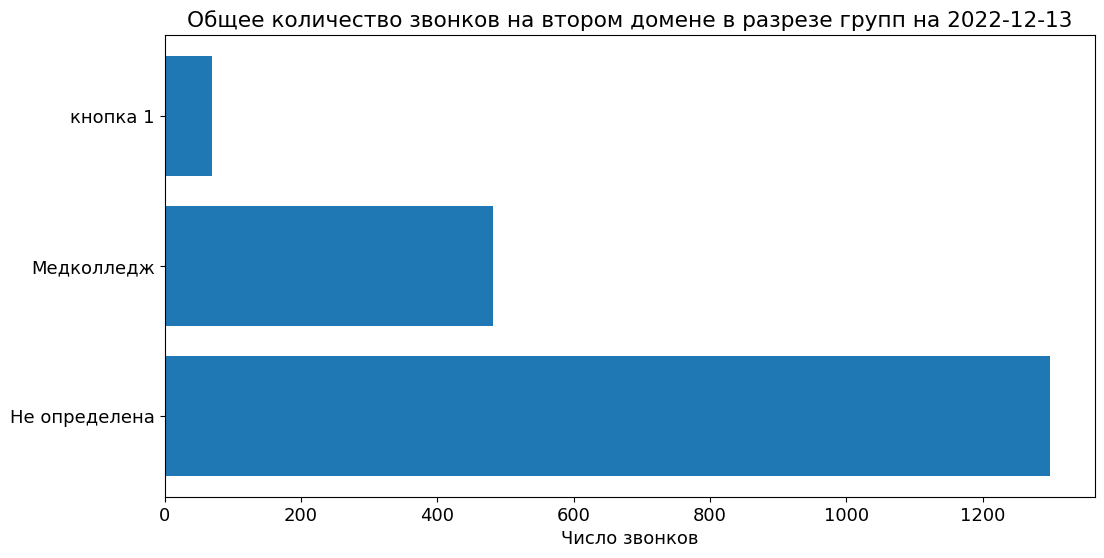

In [98]:
group_calls_RT = df_specific_day_RT.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)

if check_df_on_none(group_calls_RT):
    f = plt.figure(figsize=(12,6))
    plt.barh(group_calls_RT['Группа'], group_calls_RT['Число звонков'],label='Общее количество звонков')

    plt.xlabel('Число звонков')
    plt.title(f'Общее количество звонков на втором домене в разрезе групп на {dayRT}')

    plt.rcParams.update({'font.size': 13})
    plt.show()

### Общее количество звонков на первом домене в разрезе групп (Круговая диаграмма)

Общее количество звонков на первом домене в разрезе групп на 2022-12-13


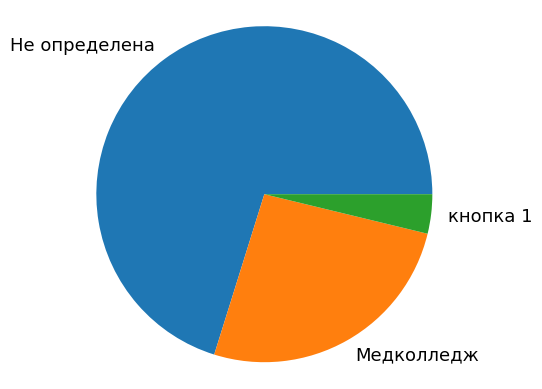

In [99]:
vals = group_calls_RT['Число звонков']
labels = group_calls_RT['Группа']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
ax.axis("equal")
print(f'Общее количество звонков на первом домене в разрезе групп на {dayRT}')

## Отчёт для ЕА

In [100]:
report_for_EA(df_specific_day, df_specific_day_RT)

Информация по вызовам на "122" за 13.12.2022:
    Всего вызовов: 1762
    Неотвеченных вызовов: 0 ( 0,0%, зеленая зона)
    Среднее время ожидания: 0,081 мин. (зеленая зона)
    


# Загрузка архивных данных ВМК, ВМК2 и Ростелеком

In [101]:
names = glob.glob(PATH_VMK + "\\*", recursive=True)
names2 = glob.glob(PATH_VMK2 + "\\*", recursive=True)
namesRT = glob.glob(PATH_ROSTELECOM + "\\*", recursive=True)

# ВМК
# Загрузка всех данных ВМК
total_all_days = create_df(names)
total_all_days['Группа'] = total_all_days['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования', 'кнопка 1':'Мобилизация'})

# Создаём датафрейм ВМК первый домен для здрава (исключена группа: кнопка 1)
total_all_days_for_medical = total_all_days[total_all_days['Группа'] != 'Мобилизация']


# ВМК2
# Загрузка всех данных ВМК2
total_all_days2 = create_df(names2)
total_all_days2['Группа'] = total_all_days2['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования', 'кнопка 1':'Мобилизация'})


# Ростелеком
# Загрузка всех данных Ростелеком

contRT=[]
for i in range(len(namesRT)):
    
    date=re.search( r'[0-9]{4}-[0-9]{2}-[0-9]{2}', namesRT[i]).group()
    df_RT = pd.read_excel(namesRT[i],dtype={'Номер вызывающего': str})
    if (dt.datetime.strptime(date, "%Y-%m-%d")<dt.datetime(2021,4,22)):
        df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')        
        df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: int(x.split(' ')[0])*60+int(x.split(' ')[1]) if len(x.split(' '))==2 else int(x.split(' ')[0]))
    else:
        df_RT['Длительность']=pd.to_timedelta(df_RT['Длительность'].astype('str'))
        df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: x.total_seconds())
    df_RT=df_RT[df_RT['Длительность'] > 9]
    
    df_RT= df_RT[['Дата вызова','Время вызова','Номер вызывающего','Номер вызываемого', 'Первый ответивший', 'Статус', 'Длительность', 'Группа']]
    df_RT['Номер вызываемого']=df_RT['Номер вызываемого'].astype('str')
    df_RT['Время вызова']=df_RT['Время вызова'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S'))
    df_RT['Дата вызова']=pd.to_datetime(df_RT['Дата вызова'])
    df_RT['День недели']=df_RT['Дата вызова'].apply(lambda x: x.weekday())
    df_RT['Час звонка']=df_RT['Время вызова'].dt.hour
    df_RT['Время вызова']=df_RT['Время вызова'].dt.time    
    contRT.append(df_RT)
    
total_all_days_RT = pd.concat(contRT,ignore_index=True)

total_all_days_RT = total_all_days_RT.rename(columns={'Первый ответивший': 'Оператор'})
total_all_days_RT['Группа']=total_all_days_RT['Группа'].replace({'Общая':'Медколледж','Консультация':'Облкомобразования'})
total_all_days_RT['Группа']=total_all_days_RT['Группа'].fillna('Не определена')
total_all_days_RT['Оператор']=total_all_days_RT['Оператор'].replace({' ':'Не определен'})

total_all_days_RT = total_all_days_RT.drop(total_all_days_RT[(total_all_days_RT['Группа'] =='Не определена') & (total_all_days_RT['Статус'] =='пропущенный')].index)
total_all_days_RT = total_all_days_RT.drop(total_all_days_RT[(total_all_days_RT['Длительность'] < 120) & (total_all_days_RT['Статус'] =='пропущенный')].index)

total_all_days_RT['Номер вызывающего']=total_all_days_RT['Номер вызывающего'].str.replace(' ', '')
total_all_days_RT['Номер вызываемого']=total_all_days_RT['Номер вызываемого'].str.replace(' ', '')
hospitals=pd.read_excel(os.path.join(".\\", DATA_SOURCE_DIRECTORY_NAME, 'Переадресация телефонов.xlsx'))
total_all_days_RT=total_all_days_RT.merge(hospitals, how = 'left', left_on='Номер вызывающего', right_on='Единый номер')

total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Государственное учреждение здравоохранения','ГУЗ')
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Государственное бюджетное учреждение здравоохранения','ГБУЗ') 
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Клиническая больница скорой медицинской помощи','КБСМП')
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('клиническая поликлиника','КП')

# Создаём датафрейм Ростелеком первый домен для здрава (исключена группа: кнопка 1)
total_all_days_RT_for_medical = total_all_days_RT.drop(total_all_days_RT[total_all_days_RT['Группа'] == 'кнопка 1'].index).copy()

# total_all_days.to_excel("ВМК1.xlsx", index=False)
# total_all_days2.to_excel("ВМК2.xlsx", index=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16156\1979979576.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')
C:\Users\Admin\AppData\Local\Temp\ipykernel_16156\1979979576.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')
C:\Users\Admin\AppData\Local\Temp\ipykernel_16156\1979979576.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')
C:\Users\Admin\AppData\Local\Temp\ipykernel_16156\1979979576.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df_RT['Длительность']=df_RT['Длительность'].str.replace( ' 

KeyboardInterrupt: 

### Для Артема ВМК1

In [ ]:
# total_all_days111 = total_all_days[total_all_days['Дата звонка'] >= dt.datetime(2022, 11, 26)]
total_all_days111 = total_all_days.copy()
total_all_days111['Дата звонка'] = total_all_days111['Дата звонка'].astype('datetime64')

total_all_days111 = total_all_days111[(total_all_days111['Дата звонка'] >= dt.datetime(2022, 10, 1)) & (total_all_days111['Дата звонка'] <= dt.datetime(2022, 10, 31))]


total_all_days111
total_all_days111['Время разговора'].sum()

39937.033327000005

### Для Артема ВМК2

In [ ]:
total_all_days222 = total_all_days2.copy()
total_all_days222['Дата звонка'] = total_all_days222['Дата звонка'].astype('datetime64')

total_all_days222 = total_all_days222[(total_all_days222['Дата звонка'] >= dt.datetime(2022, 10, 1)) & (total_all_days222['Дата звонка'] <= dt.datetime(2022, 10, 31))]


total_all_days222
total_all_days222['Время разговора'].sum() / 60

239.81249999999997

### Таблица максимального времени ожидания за все даты по первому домену (ВМК)

In [ ]:
if check_df_on_none(total_all_days):   
    report_total_max_time_wait_calls_vmk = table_waiting_time(total_all_days).head(10)
    report_total_max_time_wait_calls_vmk['Дата звонка']  = report_total_max_time_wait_calls_vmk['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
    report_total_max_time_wait_calls_vmk.to_excel(os.path.join(PATH_REPORTS, f"Отчет по максимальному времени ожидания за весь период (ВМК).xlsx"), index=False)
    display(HTML(report_total_max_time_wait_calls_vmk.to_html()))

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
1111,28.09.2022,79023839863.0,18:39:15,01:51:13,Медколледж,--,Не дождался
570,04.11.2021,78442375046,15:55:44,01:49:24,Медколледж,user7,Не дождался
199,03.01.2022,78442332132.0,15:20:36,01:43:10,Медколледж,user7,Не дождался
852,09.03.2022,79889837665.0,14:25:12,01:42:16,Медколледж,user104,Не дождался
738,09.03.2022,79197919271.0,13:19:52,01:19:45,Медколледж,user112,Не дождался
5,26.12.2020,79033729176.0,06:40:07,01:19:35,Медколледж,user3,Завершён оператором
497,04.11.2021,79275324278,15:00:05,01:17:57,Медколледж,user12,Не дождался
742,09.03.2022,78442478160.0,13:21:33,01:17:39,Медколледж,user82,Не дождался
463,04.11.2021,79880057443,14:34:50,01:14:15,Медколледж,user10,Не дождался
875,09.03.2022,79370927948.0,14:43:56,01:09:39,Медколледж,user108,Не дождался


### Таблица максимального времени ожидания за все даты по второму домену (ВМК2)

In [ ]:
if check_df_on_none(total_all_days2):   
    report_total_max_time_wait_calls_vmk2 = table_waiting_time(total_all_days2).head(10)
    report_total_max_time_wait_calls_vmk2['Дата звонка']  = report_total_max_time_wait_calls_vmk2['Дата звонка'].apply(lambda value: value.strftime('%d.%m.%Y'))
    report_total_max_time_wait_calls_vmk2.to_excel(os.path.join(PATH_REPORTS, "Отчет по максимальному времени ожидания за весь период (ВМК2).xlsx"), index=False)
    display(HTML(report_total_max_time_wait_calls_vmk2.to_html()))

,Дата звонка,Номер телефона,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
204,20.10.2022,79377323954.0,18:27:17,01:41:32,Диспансеризация-Ограничения,user54,Не дождался
14,06.02.2022,79955874425.0,07:57:08,01:07:20,Информация распространения COVID,user95,Завершён абонентом
73,22.03.2022,78443381784.0,08:44:46,01:06:21,Мониторинг больного COVID,user117,Не дождался
1815,13.02.2022,79023620629.0,19:50:49,01:05:27,Информация распространения COVID,user94,Не дождался
19,06.02.2022,79275428538.0,07:59:21,01:05:18,Информация распространения COVID,user121,Переведён
33,06.02.2022,79696504035.0,08:03:10,01:00:26,Информация распространения COVID,user93,Завершён абонентом
66,06.02.2022,79996291559.0,08:11:33,00:59:20,Информация распространения COVID,user23,Переведён
775,20.02.2022,79023113005.0,14:35:26,00:56:55,Вопросы не по COVID,--,Не дождался
4,11.10.2022,79023800788.0,06:51:16,00:53:53,Вызов врача,user52,Завершён оператором
329,28.09.2022,79377168262.0,20:14:53,00:52:43,Диспансеризация-Вопросы не по COVID,user54,Не дождался


### Таблица количества звонков по группам обращений за весь период (ВМК2)

In [ ]:
group_calls_VMK2 = total_all_days2.groupby("Группа")["Группа"].count().reset_index(name="Число звонков")
group_calls_VMK2.to_excel(os.path.join(PATH_REPORTS, "Количество звонков по группам обращений за весь период (ВМК2).xlsx"), index=False)

print(f'Количество звонков по всем группам: {group_calls_VMK2["Число звонков"].sum()}')
display(HTML(group_calls_VMK2.to_html()))

Количество звонков по всем группам: 108784


,Группа,Число звонков
0,БЕЖЕНЫ,219
1,Вопросы не по COVID,6929
2,Вызов врача,76312
3,Диспансеризация-Вопросы не по COVID,775
4,Диспансеризация-Ограничения,1496
5,Информация распространения COVID,22711
6,Медколледж,83
7,Мониторинг больного COVID,90
8,Мониторинг больного COVID и БЕЖЕНЫ,169


In [ ]:
# Что это?
tmp=total_all_days[(total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
tmp2=total_all_days [ (total_all_days['Статус звонка']!='Не дождался') & (total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
Total = tmp2['Число звонков'].sum()

print(tmp2)
print(Total)

   Дата звонка  Число звонков
0   2021-04-01           1021
1   2021-04-02            841
2   2021-04-03            216
3   2021-04-04            126
4   2021-04-05           1555
5   2021-04-06           1061
6   2021-04-07           1153
7   2021-04-08            884
8   2021-04-09            964
9   2021-04-10            154
10  2021-04-11             85
11  2021-04-12           1414
12  2021-04-13            851
13  2021-04-14            581
14  2021-04-15            618
15  2021-04-16            686
16  2021-04-17            105
17  2021-04-18             81
18  2021-04-19           1232
19  2021-04-20            755
20  2021-04-21            725
21  2021-04-22            556
22  2021-04-23            513
23  2021-04-24            131
24  2021-04-25             66
25  2021-04-26           1140
26  2021-04-27            956
27  2021-04-28            475
28  2021-04-29            369
29  2021-04-30            417
19731


# Отчет по количеству звонков и максимальному времени ожидания (Все группы)

In [ ]:
START_DAY = dt.datetime(2022,1,1) 
END_DAY = dt.datetime(2022,12,13) 

df_all_calls_vmk = total_all_days.copy()
df_all_calls_vmk['Дата звонка'] = df_all_calls_vmk['Дата звонка'].astype('datetime64')
df_all_calls_vmk = df_all_calls_vmk[(df_all_calls_vmk['Дата звонка'] >= START_DAY) & (df_all_calls_vmk['Дата звонка'] <= END_DAY)]

df_all_calls_rostelecom = total_all_days_RT.copy()
df_all_calls_rostelecom = df_all_calls_rostelecom[(df_all_calls_rostelecom['Дата вызова'] >= START_DAY) & (df_all_calls_rostelecom['Дата вызова'] <= END_DAY)]

all_days_rostelecom = list(df_all_calls_rostelecom['Дата вызова'].dt.date.unique())
all_days = list(df_all_calls_vmk['Дата звонка'].dt.date.unique())
lists_new_dt = []

for i in all_days:
    df_report = df_all_calls_vmk[df_all_calls_vmk['Дата звонка']== str(i)].copy()
    df_tmp_rostelecom = df_all_calls_rostelecom[(df_all_calls_rostelecom['Дата вызова']== str(i)) & (df_all_calls_rostelecom['Номер вызываемого']=='78442325552')].copy()
    lists_new_dt.append([str(i), round(df_tmp_rostelecom['Дата вызова'].count(), 1), round(df_report['Время ожидания'].max(), 1)])
   
df_report = pd.DataFrame(lists_new_dt)
df_report = df_report.rename(columns={0: "Дата вызова", 1: "Количество звонков", 2: "Максимальное время ожидания"})


df_report.to_excel(os.path.join(PATH_REPORTS, 'Отчет по количеству звонков и макс. времени.xlsx'), index=False) 
print(df_report)
print(f"Колитчество звонков: {df_report['Количество звонков'].sum()}")

    Дата вызова  Количество звонков  Максимальное время ожидания
0    2022-01-01                  58                          0.3
1    2022-01-02                 115                          1.0
2    2022-01-03                 223                        103.2
3    2022-01-04                 169                          6.9
4    2022-01-05                 157                          2.3
..          ...                 ...                          ...
301  2022-12-09                1091                          1.8
302  2022-12-10                 581                          0.4
303  2022-12-11                 669                          0.5
304  2022-12-12                4652                          1.5
305  2022-12-13                1762                          0.8

[306 rows x 3 columns]
Колитчество звонков: 215836


# Отчет по количеству звонков и максимальному времени ожидания (Здрав)

In [ ]:
START_DAY = dt.datetime(2022,10,1) 
END_DAY = dt.datetime(2022,10,30) 


df_all_calls_vmk = total_all_days_for_medical.copy()
df_all_calls_vmk['Дата звонка'] = df_all_calls_vmk['Дата звонка'].astype('datetime64')
df_all_calls_vmk = df_all_calls_vmk[(df_all_calls_vmk['Дата звонка'] >= START_DAY) & (df_all_calls_vmk['Дата звонка'] <= END_DAY)]

df_all_calls_rostelecom = total_all_days_RT_for_medical.copy()
df_all_calls_rostelecom = df_all_calls_rostelecom[(df_all_calls_rostelecom['Дата вызова'] >= START_DAY) & (df_all_calls_rostelecom['Дата вызова'] <= END_DAY)]

all_days_rostelecom = list(df_all_calls_rostelecom['Дата вызова'].dt.date.unique())
all_days = list(df_all_calls_vmk['Дата звонка'].dt.date.unique())
lists_new_dt = []

for i in all_days_rostelecom:
    df_report = df_all_calls_vmk[df_all_calls_vmk['Дата звонка']== str(i)].copy()
    df_tmp_rostelecom = df_all_calls_rostelecom[(df_all_calls_rostelecom['Дата вызова']== str(i)) & (df_all_calls_rostelecom['Номер вызываемого']=='78442325552')].copy()
    lists_new_dt.append([str(i), round(df_tmp_rostelecom['Дата вызова'].count(), 1), round(df_report['Время ожидания'].max(), 1)])
   
df_report = pd.DataFrame(lists_new_dt)
df_report = df_report.rename(columns={0: "Дата вызова", 1: "Количество звонков", 2: "Максимальное время ожидания"})


df_report.to_excel(os.path.join(PATH_REPORTS, 'Отчет по количеству звонков и макс. времени.xlsx'), index=False) 
print(df_report)

   Дата вызова  Количество звонков  Максимальное время ожидания
0   2022-10-01                 614                          2.4
1   2022-10-02                 259                          3.0
2   2022-10-03                 642                          2.4
3   2022-10-04                 632                          1.6
4   2022-10-05                 548                          3.8
5   2022-10-06                 354                          1.0
6   2022-10-07                 395                          1.6
7   2022-10-08                 200                          0.3
8   2022-10-09                 156                          1.0
9   2022-10-10                 449                          3.0
10  2022-10-11                 448                          2.3
11  2022-10-12                 392                          2.5
12  2022-10-13                 433                         28.8
13  2022-10-14                 334                          0.3
14  2022-10-15                 129      

### Выгрузка по успешным звонкам за период

In [ ]:
start_RT = '2020-11-27'
end_RT = '2022-08-22'
tmp_RT=total_all_days_RT[(total_all_days_RT['Статус']=='успешный') & (total_all_days_RT['Дата вызова']>=pd.to_datetime(start_RT)) & (total_all_days_RT['Дата вызова']<=pd.to_datetime(end_RT))].groupby('Дата вызова')['Время вызова'].count().reset_index(name="Число звонков")
Total = tmp_RT['Число звонков'].sum()

tmp_RT.to_excel(os.path.join(PATH_REPORTS,"Отчет по успешным звонкам за период.xlsx"),  index=False)
print(f'Всего звонков: {Total}')

tmp_RT.to_excel(os.path.join(PATH_REPORTS, 'Отчет по успешным звонкам за период.xlsx'), index=False) 
tmp_RT

Всего звонков: 260711


,Дата вызова,Число звонков
0,2021-04-08,928
1,2021-04-09,1009
2,2021-04-10,188
3,2021-04-11,90
4,2021-04-12,1396
...,...,...
453,2022-08-16,521
454,2022-08-17,569
455,2022-08-18,491
456,2022-08-19,507


### Всего звонков

In [ ]:
start_RT = '2022-01-01'
end_RT = '2022-12-13'
tmp_RT=total_all_days_RT[(total_all_days_RT['Дата вызова']>=pd.to_datetime(start_RT)) & (total_all_days_RT['Дата вызова']<=pd.to_datetime(end_RT))].groupby('Дата вызова')['Время вызова'].count().reset_index(name="Число звонков")
Total = tmp_RT['Число звонков'].sum()
# tmp_RT.to_excel("Всего звонков.xlsx")
print(f'Всего звонков: {Total}')
tmp_RT

Всего звонков: 223407


,Дата вызова,Число звонков
0,2022-01-01,58
1,2022-01-02,115
2,2022-01-03,223
3,2022-01-04,173
4,2022-01-05,160
...,...,...
299,2022-12-09,1157
300,2022-12-10,597
301,2022-12-11,679
302,2022-12-12,4676


### Для заполнения таблицы  комитета здравоохранения

In [ ]:
# 3 Всего количество обращений (за отчетный период
# 4 Всего количество обращений (нарастающим итогом с 01.01.2022)
# 5 Количество обращений (за отчетный период) по вопросам здравоохранения (организации и оказания мед.помощи)
# 6 Количество обращений (нарастающим итогом с 01.01.2022) по вопросам здравоохранения (организации и оказания мед.помощи)  
# 7 Количество обращений (за отчетный период) по вопросам covid - 19 (организации и оказания мед.помощи)  
# 8 Количество обращений (нарастающим итогом с 01.01.2022) по вопросам covid - 19 (организации и оказания мед.помощи)  

first_January = dt.datetime(2022,1,1)
first_January_VMK2 = dt.datetime(2022,2,7)
k8 = 36372 # истерически сложилось
k4= 6505 #1762 # истерически сложилось

# ОПРЕДЕЛЯЕМ 7 ДНЕВНЫЙ ПЕРИОД !!!
start_day=dt.datetime(2022,1,1)
finish_day=dt.datetime(2022,12,13)

# убираем переадресованные вызовы
total_all_lucky_days_RT = total_all_days_RT[total_all_days_RT['Оператор'] != 'Не определен']

# Создаём датафрейм для первого домена Ростелеком с 1 янворя 2022 года 
df_1_to_finish_day_RT = total_all_lucky_days_RT[(total_all_lucky_days_RT['Дата вызова'] >= first_January) & (total_all_lucky_days_RT['Дата вызова'] <= finish_day)]
# Удаляем данные касательно кнопки 1
df_1_to_finish_day_RT = df_1_to_finish_day_RT.drop(df_1_to_finish_day_RT[df_1_to_finish_day_RT['Группа'] == 'кнопка 1'].index)

# Создаём датафрейм для первого домена Ростелеком за определенный период 
df_period_day_RT = total_all_lucky_days_RT[(total_all_lucky_days_RT['Дата вызова'] >= start_day) & (total_all_lucky_days_RT['Дата вызова'] <= finish_day)]
# Удаляем данные касательно кнопки 1
df_period_day_RT = df_period_day_RT.drop(df_period_day_RT[df_period_day_RT['Группа'] == 'кнопка 1'].index)


# Создаём датафрейм для второго домена ВМК (Вызов врача и Вопросы не по covid-19)
df_healthcare_calls_VMK2 = total_all_days2[(total_all_days2['Группа'] == 'Вызов врача') | (total_all_days2['Группа'] == 'Вопросы не по COVID')]
# Вычеслдяем количество звонков с 1 янворя 2022 года 
count_1_to_finish_healthcare_calls_VMK2 = df_healthcare_calls_VMK2[(df_healthcare_calls_VMK2['Дата звонка'] >= first_January_VMK2.date()) & (df_healthcare_calls_VMK2['Дата звонка'] <= finish_day.date())].shape[0] 
# Вычеслдяем количество звонков за определенный период
count_healthcare_calls_VMK2 = df_healthcare_calls_VMK2[(df_healthcare_calls_VMK2['Дата звонка'] >= start_day.date()) & (df_healthcare_calls_VMK2['Дата звонка'] <= finish_day.date())].shape[0] 

# Создаём датафрейм для второго домена ВМК по вопросам covid - 19 (Информация распространения COVID и Мониторинг больного COVID)
df_covid_calls_VMK2 = total_all_days2[(total_all_days2['Группа'] == 'Информация распространения COVID') | (total_all_days2['Группа'] == 'Мониторинг больного COVID')]

# Вычеслдяем количество звонков по вопросам covid - 19 с 1 янворя 2022 года 
count_1_to_covid_calls_VMK2 = df_covid_calls_VMK2[(df_covid_calls_VMK2['Дата звонка'] >= first_January_VMK2.date()) & (df_covid_calls_VMK2['Дата звонка'] <= finish_day.date())].shape[0]
# Вычеслдяем количество звонков по вопросам covid - 19
count_covid_calls_VMK2 = df_covid_calls_VMK2[(df_covid_calls_VMK2['Дата звонка'] >= start_day.date()) & (df_covid_calls_VMK2['Дата звонка'] <= finish_day.date())].shape[0] 

print(f"""3 Всего количество обращений (c {start_day.day} по {finish_day.day} число): {df_period_day_RT.shape[0]}
4 Всего количество обращений (c нарастающим итогом с 01.01.2022 по {finish_day.day} число): {df_1_to_finish_day_RT.shape[0] + k4}
5 Количество обращений (c {start_day.day} по {finish_day.day} число) по вопросам здравоохранения: {count_healthcare_calls_VMK2}
6 Количество обращений (c нарастающим итогом с 01.01.2022 по {finish_day.day} число)по вопросам здравоохранения: {count_1_to_finish_healthcare_calls_VMK2}
7 Количество обращений (за отчетный период) по вопросам covid - 19 (организации и оказания мед.помощи): {count_covid_calls_VMK2}
8 Количество обращений (нарастающим итогом с 01.01.2022) по вопросам covid - 19 (организации и оказания мед.помощи): {count_1_to_covid_calls_VMK2 + k8}

""")
print(pd.DataFrame([{"3": df_period_day_RT.shape[0],"4": df_1_to_finish_day_RT.shape[0] + k4,"5": count_healthcare_calls_VMK2,"6": count_1_to_finish_healthcare_calls_VMK2,"7": count_covid_calls_VMK2, "8": count_1_to_covid_calls_VMK2 + k8}], index=[' ']))

3 Всего количество обращений (c 1 по 13 число): 190113
4 Всего количество обращений (c нарастающим итогом с 01.01.2022 по 13 число): 196618
5 Количество обращений (c 1 по 13 число) по вопросам здравоохранения: 83241
6 Количество обращений (c нарастающим итогом с 01.01.2022 по 13 число)по вопросам здравоохранения: 81329
7 Количество обращений (за отчетный период) по вопросам covid - 19 (организации и оказания мед.помощи): 22801
8 Количество обращений (нарастающим итогом с 01.01.2022) по вопросам covid - 19 (организации и оказания мед.помощи): 58410


        3       4      5      6      7      8
   190113  196618  83241  81329  22801  58410


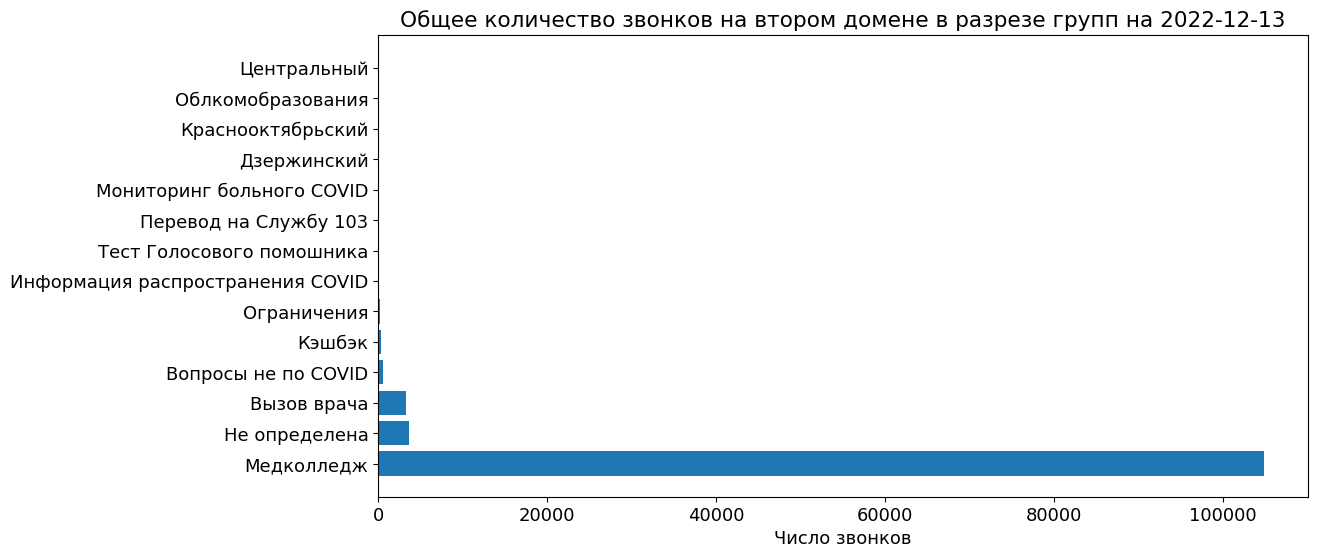

In [ ]:
##################################################

startDayRT=dt.datetime(2022,1,1) 
endDayRT=dt.datetime(2022,3,31) 
 
df_med_day_RT=total_all_days_RT[(total_all_days_RT['Статус']=='успешный') & (total_all_days_RT['Дата вызова']>=pd.to_datetime(startDayRT)) & (total_all_days_RT['Дата вызова']<=pd.to_datetime(endDayRT))] 
 
df_med_day_RT 
 
group_calls_RT2=df_med_day_RT.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False) 
 
f = plt.figure(figsize=(12,6)) 
plt.barh(group_calls_RT2['Группа'], group_calls_RT2['Число звонков'],label='Общее количество звонков') 
 
plt.xlabel('Число звонков') 
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {dayRT}') 
 
plt.rcParams.update({'font.size': 13}) 
plt.show()
# df_med_day_RT['Дата вызова'].to_excel("1PT.xlsx")
# group_calls_RT2.to_excel("Первый домен РТ.xlsx")

C:\Users\Admin\AppData\Local\Temp\ipykernel_16156\2028962909.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_med_day_WMK=total_all_days2[(total_all_days2['Дата звонка']>=pd.to_datetime(startDayRT)) & (total_all_days2['Дата звонка']<=pd.to_datetime(endDayRT))]


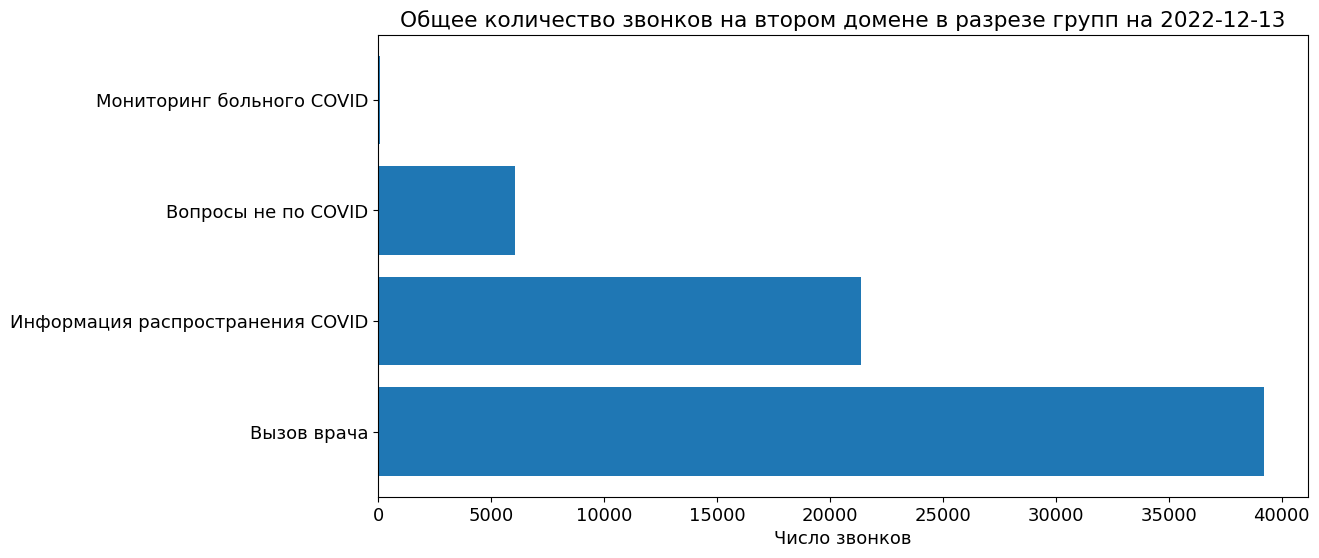

In [ ]:
df_med_day_WMK=total_all_days2[(total_all_days2['Дата звонка']>=pd.to_datetime(startDayRT)) & (total_all_days2['Дата звонка']<=pd.to_datetime(endDayRT))] 
 
df_med_day_WMK 
 
group_calls_WMK=df_med_day_WMK.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False) 

f = plt.figure(figsize=(12,6)) 
plt.barh(group_calls_WMK['Группа'], group_calls_WMK['Число звонков'],label='Общее количество звонков') 
 
plt.xlabel('Число звонков') 
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {dayRT}') 
 
plt.rcParams.update({'font.size': 13}) 
plt.show()

# group_calls_WMK.to_excel("Второй домен ВМК.xlsx")

### Количество звноков по мобилизации за период

In [ ]:
start_day_report = dt.datetime(2022,9,22) 
end_day_report = dt.datetime(2022,12,13) 

# df_report = total_all_days[(total_all_days['Час звонка'] >= START_HOUR_JOB) & (total_all_days['Час звонка'] < END_HOUR_JOB) & (total_all_days['Дата звонка'] >= start_day_report.date()) & (total_all_days['Дата звонка'] <= end_day_report.date()) & (total_all_days["Группа"] == "Мобилизация")].copy()
df_report = total_all_days[(total_all_days['Дата звонка'] >= start_day_report.date()) & (total_all_days['Дата звонка'] <= end_day_report.date()) 
            & (total_all_days["Группа"] == "Мобилизация")].copy()
number_calls = df_report.shape[0]

report_list = list()

values_for_report_mob_vmk_all = {}
start_day_report_ = start_day_report
while start_day_report_ <= end_day_report:
    values_for_report_mob_vmk = calculate_values_for_report_vmk(df_report[df_report['Дата звонка'] == start_day_report_.date()])
    
    # Создан костыль из-за необходимости ручной корректировки даты: 2022-10-01	
    if start_day_report_ != dt.datetime(2022,10,1): 
        report_list.append([start_day_report_.date().strftime('%d.%m.%Y'), values_for_report_mob_vmk.get('total_number_calls', None), 
                            values_for_report_mob_vmk.get('SL_for_10_minutes', None), values_for_report_mob_vmk.get('max_time_wait_call', None), 
                            values_for_report_mob_vmk.get('mean_time_wait_call', None), values_for_report_mob_vmk.get('mean_time_talked_on_phone', None),
                            values_for_report_mob_vmk.get('number_users_work_for_day', None), values_for_report_mob_vmk.get('list_users_work_for_day', None)])
    else:
        # Ручная корректировка 2022-10-01
        report_list.append([start_day_report_.strftime('%d.%m.%Y'), 542, 94.00, 0.8, 0.2, 2.60, values_for_report_mob_vmk.get('number_users_work_for_day'), 
                            values_for_report_mob_vmk.get('list_users_work_for_day')])
        
    values_for_report_mob_vmk_all[start_day_report_] = values_for_report_mob_vmk
    start_day_report_ += dt.timedelta(1)


df_report = pd.DataFrame(report_list, columns=['Дата', 'Количество звонков' , 'SL за10 сек., %', 'Максимальное время ожидания', 'Среднее время ожидания', 
                                               'Среднее время разговора', 'Количество users', 'Список users'])


# "number_calls + 506" из-за ручной корректировки даты: 2022-10-01  
print(f"""Статистика по частичной мобилизации в РФ (по номеру 122) за период с {start_day_report.date().strftime('%d.%m.%Y')} по {end_day_report.date().strftime('%d.%m.%Y')}.
Всего звонков: {number_calls + 506}
Среднее количество звонков: {round((number_calls + 506) / ((end_day_report - start_day_report).days + 1))}""")

# Выгрузка отчета - сделать
df_report.to_excel(os.path.join(PATH_REPORTS,"Отчет по мобилизации за период.xlsx"), index=False)
df_report.tail(15)


Статистика по частичной мобилизации в РФ (по номеру 122) за период с 22.09.2022 по 13.12.2022.
Всего звонков: 22484
Среднее количество звонков: 271


,Дата,Количество звонков,"SL за10 сек., %",Максимальное время ожидания,Среднее время ожидания,Среднее время разговора,Количество users,Список users
68,29.11.2022,67,100.00,0.2,0.1,2.6,7,"user106, user107, user108, user109, user112, u..."
69,30.11.2022,53,98.11,6.4,0.2,2.1,9,"user106, user107, user108, user109, user57, us..."
70,01.12.2022,55,98.18,0.2,0.1,2.1,6,"user107, user112, user57, user61, user87, user89"
71,02.12.2022,47,95.74,0.7,0.1,3.1,7,"user106, user107, user108, user57, user61, use..."
72,03.12.2022,25,100.00,0.1,0.1,2.3,6,"user106, user107, user108, user109, user57, us..."
73,04.12.2022,33,96.97,0.2,0.1,2.6,4,"user109, user57, user61, user85"
74,05.12.2022,55,89.09,0.8,0.1,1.8,5,"user57, user61, user85, user87, user89"
75,06.12.2022,27,92.59,0.6,0.1,2.6,8,"user106, user107, user108, user57, user61, use..."
76,07.12.2022,32,93.75,0.9,0.1,3.2,8,"user107, user108, user109, user57, user61, use..."
77,08.12.2022,6,83.33,0.3,0.1,3.5,3,"user109, user57, user61"
